# Logistic Regression Classifier - Fitting to all stroke teams together
## Including shapley value analysis

This notebook is based on the original notebook "logistic_regression_single_fit.ipynb", which has these aims.

## Aims

Assess accuracy of a logistic regression classifier, using k-fold (5-fold) training/test data splits (each data point is present in one and only one of the five test sets). This notebook fits all data in a single model, with hospital ID being a one-hot encoded feature.

The notebook includes:

* A range of accuracy scores
* Receiver operating characteristic (ROC) and Sensitivity-Specificity Curves 
* Identify feature weights (model coefficients)
* Performing a learning rate test (relationship between training set size and accuracy)

This notebook extends "logistic_regression_single_fit.ipynb" to include Shapley value analysis (comparing them to feature weights, and creating beeswarm and waterfall plots).


## Aims extension:

1. Calculate Shapley values for the logistic regression model

Shapley values are calculated per instance, per feature. To get a value per feature take the mean of all the instances. Do this for each k-fold.
    
1. Get average and standard deviation of Shapley values and model weights for each of the five k-fold splits

For shapley values this becomes the mean of the 5 means (one for each of the 5 kfolds)
    
1. Plot mean Shapley value vs mean weight - and put an error bar of standard error (SD / root(n)) for each

1. Show the top 10 (absolute value) Shapley values and model weights

1. Combine all the data (so no train/test split) - refit and get Shapley values and model weights, and show a Beeswarm plot for all the data, and then show a Waterfall plot for three examples (pref in a single wide MatPlotLib plot) - one with a low probability of giving thrombolysis, one with a probability close to 0.5, and one with a high probability of giving thrombolysis.

Beeswarm uses all the data, waterfall plot shows individual instances (so choose 3 instances).

Using code from https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c to create the SHAP plots, and transform the log-odds to probabilities for Waterfall plot.

Things I learnt: 
1. SHAP plots can display either the original feature value, or the standardised value, depending on which argument you pass
1. dataset needs to be a pandas DataFrame for the plot to include the feature names. The function "standardise_data()" returns a numpy array - hence why the plots weren't displaying feature names.
1. Can not work out how to plot waterfall plots in subplots, in order to display them side-by-side.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

#### Install shap if necessary (e.g. running in Google Colab)

In [2]:
try:
    import shap
except:
    !pip install shap
    import shap

# Install math for sqrt
import math

## Import data

Data has previously been split into 5 training/test splits.

In [3]:
data_loc = './data/kfold_5fold/'

In [4]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(data_loc + 'train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(data_loc + 'test_{0}.csv'.format(i)))

In [5]:
train_data[0]

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,...,S2NewAFDiagnosis_No,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing
0,JXJYG0100P,72.5,125.0,0,0,0.0,0.0,1.0,3.0,2.0,...,0,0,1,1,0,0,0,0,0,1
1,JXJYG0100P,67.5,50.0,0,0,2.0,1.0,0.0,0.0,1.0,...,0,0,1,1,0,0,0,0,0,1
2,UIWEN7236N,77.5,47.0,0,0,0.0,0.0,0.0,2.0,2.0,...,1,0,0,1,0,0,0,0,0,1
3,LFPMM4706C,82.5,75.0,0,0,1.0,0.0,0.0,0.0,2.0,...,0,0,1,1,0,0,0,0,0,1
4,UIWEN7236N,57.5,44.0,1,0,2.0,0.0,1.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71137,NZNML2841Q,77.5,103.0,4,0,0.0,0.0,0.0,0.0,2.0,...,0,0,1,1,0,0,0,0,0,1
71138,IYJHY1440E,92.5,87.0,3,2,2.0,2.0,0.0,0.0,0.0,...,0,0,1,1,0,0,1,0,0,0
71139,GLRVJ5773V,87.5,73.0,2,0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,1
71140,KZKEZ2257Z,62.5,71.0,4,2,2.0,2.0,1.0,2.0,0.0,...,1,0,0,0,1,0,0,0,0,1


## Functions 

### Standardise data

Standardisation subtracts the mean and divides by the standard deviation, for each feature. Here we use the sklearn built-in method for standardisation.

In [6]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

### Calculate accuracy measures

In [7]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_negatives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

### Find model probability threshold to match predicted and actual thrombolysis use

In [8]:
def find_threshold(probabilities, true_rate):
    
    """
    Find classification threshold to calibrate model
    """
    
    index = (1-true_rate)*len(probabilities)
    
    threshold = sorted(probabilities)[int(index)]
    
    return threshold

### Line intersect

Used to find point of sensitivity-specificity curve where sensitivity = specificity.

In [9]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

### Create new folder

If a folder does not exist, create it.

This is used when saving a file to a folder

In [10]:
def create_folder_if_not_exist(output_path):

    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    return()

## Getting Shapley values with SHAP

We use the `explainer` and `shap_values` methods from the SHAP library to get Shapley values.

A slight confusion is that we can get Shapley values alone, or with other variables.

In [11]:
def calculate_shapley_values(model, X_train):
    # We can use the `explainer(X)` method to get objects with shap values, base value*, and feature data.
    # *The base value is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat).

    # Train explainer on Training set
    explainer = shap.Explainer(model, X_train)
    
    # To get Shapley values alone:
    shap_values = explainer.shap_values(X_train)

    # Get Shapley values along with base, and features
    shap_values_extended = explainer(X_train)
    
    return (shap_values, shap_values_extended)

# Part 1: Fit logistic regression model using training and test sets (use k-fold splits)

In [12]:
# Set up list to store models and calibarion threshold
single_models = []
thresholds_calibrate = []

# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []
shap_values_train = []
shap_values_ext_train = []
shap_values_test = []
shap_values_ext_test = []

# Set up list for feature weightsd
feature_weights = []

# Loop through k folds
for k_fold in range(5):
    
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]
    
    # Get X and y
    X_train = train.drop('S2Thrombolysis', axis=1)
    X_test = test.drop('S2Thrombolysis', axis=1)
    y_train = train['S2Thrombolysis']
    y_test = test['S2Thrombolysis']
    
    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('StrokeTeam', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('StrokeTeam', axis=1, inplace=True)
    
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Define and Fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std, y_train)
    
    # Get feature weights
    weights = model.coef_[0]
    feature_weights.append(weights)
    
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test_std)[:,1]
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Calibrate model and get class
    true_rate = np.mean(y_test)
    threshold = find_threshold(y_probs, true_rate)
    thresholds_calibrate.append(threshold)
    y_class = y_probs >= threshold
    y_class = np.array(y_class) * 1.0
    predicted.append(y_class)
    
    # Calculate Shapley values
    ### Global influence of features in the training set
    ### Here we are looking at Shapley values for the training set, to understand the influence of features in training.
    (shapley_values, shapley_values_extended) = calculate_shapley_values(model, X_train_std)
    shap_values_train.append(shapley_values)
    shap_values_ext_train.append(shapley_values_extended)

    ### And for the Test set
    (shapley_values, shapley_values_extended) = calculate_shapley_values(model, X_test_std)
    shap_values_test.append(shapley_values)
    shap_values_ext_test.append(shapley_values_extended)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {k_fold}, accuracy: {accuracy:0.3f}, threshold {threshold:0.3f}')

Run 0, accuracy: 0.833, threshold 0.474
Run 1, accuracy: 0.834, threshold 0.475
Run 2, accuracy: 0.830, threshold 0.469
Run 3, accuracy: 0.833, threshold 0.470
Run 4, accuracy: 0.833, threshold 0.470


## Results 

### Accuracy measures 

In [13]:
# Set up list for results
k_fold_results = []

# Loop through k fold predictions and get accuracy measures
for i in range(5):
    results = calculate_accuracy(observed[i], predicted[i])
    k_fold_results.append(results)
    
# Put results in DataFrame
single_fit_results = pd.DataFrame(k_fold_results).T

In [14]:
single_fit_results

,0,1,2,3,4
observed_positive_rate,0.295232,0.295401,0.295176,0.295080,0.295417
observed_negative_rate,0.704768,0.704599,0.704824,0.704920,0.704583
predicted_positive_rate,0.295232,0.295457,0.295176,0.295080,0.295417
predicted_negative_rate,0.704768,0.704543,0.704824,0.704920,0.704583
accuracy,0.832565,0.833858,0.830316,0.833343,0.833455
precision,0.716435,0.718744,0.712571,0.717607,0.718120
recall,0.716435,0.718881,0.712571,0.717607,0.718120
f1,0.716435,0.718812,0.712571,0.717607,0.718120
sensitivity,0.716435,0.718881,0.712571,0.717607,0.718120
specificity,0.881213,0.882062,0.879627,0.881790,0.881813


In [15]:
single_fit_results.T.describe()

,observed_positive_rate,observed_negative_rate,predicted_positive_rate,predicted_negative_rate,accuracy,precision,recall,f1,sensitivity,specificity,positive_likelihood,negative_likelihood,false_positive_rate,false_negative_rate,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.295261,0.704739,0.295273,0.704727,0.832707,0.716695,0.716723,0.716709,0.716723,0.881301,6.038613,0.321434,0.118699,0.283277,0.716723,0.881301,0.716723,0.881301
std,0.000146,0.000146,0.000161,0.000161,0.001417,0.002456,0.002485,0.002471,0.002485,0.000986,0.070457,0.003182,0.000986,0.002485,0.002485,0.000986,0.002485,0.000986
min,0.295080,0.704583,0.295080,0.704543,0.830316,0.712571,0.712571,0.712571,0.712571,0.879627,5.919679,0.318707,0.117938,0.281119,0.712571,0.879627,0.712571,0.879627
25%,0.295176,0.704599,0.295176,0.704583,0.832565,0.716435,0.716435,0.716435,0.716435,0.881213,6.031237,0.319660,0.118187,0.281880,0.716435,0.881213,0.716435,0.881213
50%,0.295232,0.704768,0.295232,0.704768,0.833343,0.717607,0.717607,0.717607,0.717607,0.881790,6.070604,0.320250,0.118210,0.282393,0.717607,0.881790,0.717607,0.881790
75%,0.295401,0.704824,0.295417,0.704824,0.833455,0.718120,0.718120,0.718120,0.718120,0.881813,6.076135,0.321790,0.118787,0.283565,0.718120,0.881813,0.718120,0.881813
max,0.295417,0.704920,0.295457,0.704920,0.833858,0.718744,0.718881,0.718812,0.718881,0.882062,6.095409,0.326762,0.120373,0.287429,0.718881,0.882062,0.718881,0.882062


### Receiver Operator Characteristic and Sensitivity-Specificity Curves

Receiver Operator Characteristic Curve:

In [16]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(5):
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    roc_auc = auc(fpr, tpr)
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    print (f'Run {i} AUC {roc_auc:0.4f}')

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.9035
Run 1 AUC 0.9056
Run 2 AUC 0.9014
Run 3 AUC 0.9036
Run 4 AUC 0.9045

Mean AUC: 0.9037
SD AUC: 0.0014


Sensitivity-specificity curve:

In [17]:
k_fold_sensitivity = []
k_fold_specificity = []

for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = observed[i]
    proba = predicted_proba[i]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

Combined plot:

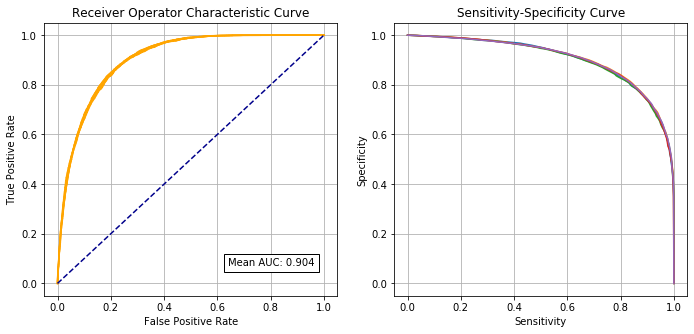

In [18]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)

output_path = './output/'
create_folder_if_not_exist(output_path)

#plt.savefig(output_path + 'lr_single_fit_roc_sens_spec.jpg', dpi=300)
plt.savefig(output_path + 'lr_single_fit_roc_sens_spec.png', dpi=300)

plt.show()

### Identify cross-over of sensitivity and specificity

In [19]:
sens = np.array(k_fold_sensitivity).mean(axis=0)
spec = np.array(k_fold_specificity).mean(axis=0)
df = pd.DataFrame()
df['sensitivity'] = sens
df['specificity'] = spec
df['spec greater sens'] = spec > sens

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersect = get_intersect(a1, a2, b1, b2)[0]
print(f'\nIntersect: {intersect:0.3f}')


Intersect: 0.820


### Collate and save results 

In [20]:
hospital_results = []
kfold_result = []
threshold_results = []
observed_results = []
prob_results = []
predicted_results = []

for i in range(5):
    hospital_results.extend(list(test_data[i]['StrokeTeam']))
    kfold_result.extend(list(np.repeat(i, len(test_data[i]))))
    threshold_results.extend(list(np.repeat(thresholds_calibrate[i], len(test_data[i]))))
    observed_results.extend(list(observed[i]))
    prob_results.extend(list(predicted_proba[i]))
    predicted_results.extend(list(predicted[i]))    
    
single_model = pd.DataFrame()
single_model['hospital'] = hospital_results
single_model['observed'] = np.array(observed_results) * 1.0
single_model['prob'] = prob_results
single_model['predicted'] = predicted_results
single_model['k_fold'] = kfold_result
single_model['threshold'] = threshold_results
single_model['correct'] = single_model['observed'] == single_model['predicted']

# Save
output_path = './predictions/'
create_folder_if_not_exist(output_path)
filename = output_path + 'single_fit_rf_k_fold.csv'
single_model.to_csv(filename, index=False)

## Feature Weights

Get Logistic Regression weights (average across k-fold results).
Sort by absolute value of weight.

KP edited to calculate the std dev as well as the mean weight

In [21]:
features = X_test.columns.values

#number of values contributing to the mean calculation
n = len(feature_weights)

# Get average feature importance from k-fold
weights = np.array(feature_weights).mean(axis = 0)
weights = pd.DataFrame(data = weights, index=features)
weights.columns = ['weight_mean']
weights['weight_std_dev'] = np.array(feature_weights).std(axis = 0)
weights['weight_std_error'] = weights['weight_std_dev']/math.sqrt(n)
weights['weight_mean_abs'] = abs(weights['weight_mean'])

# Sort by importance (absolute weight)
weights.sort_values(by='weight_mean_abs', ascending=False, inplace=True)

# Save
weights.to_csv('output/lr_single_fit_feature_weights.csv')

# Display top 25
weights.head(25)

,weight_mean,weight_std_dev,weight_std_error,weight_mean_abs
S2BrainImagingTime_min,-18.492406,0.999903,0.447170,18.492406
S2StrokeType_Infarction,2.017890,0.346172,0.154813,2.017890
S2StrokeType_Primary Intracerebral Haemorrhage,-2.009115,0.348024,0.155641,2.009115
S2RankinBeforeStroke,-0.496541,0.005185,0.002319,0.496541
AFAnticoagulent_Yes,-0.386647,0.013555,0.006062,0.386647
Loc,-0.376646,0.003893,0.001741,0.376646
BestLanguage,0.307656,0.005543,0.002479,0.307656
S1OnsetDateType_Stroke during sleep,-0.300494,0.012033,0.005381,0.300494
S1OnsetTimeType_Precise,0.289682,0.002536,0.001134,0.289682
S1OnsetTimeType_Best estimate,-0.289682,0.002536,0.001134,0.289682


Line chart:

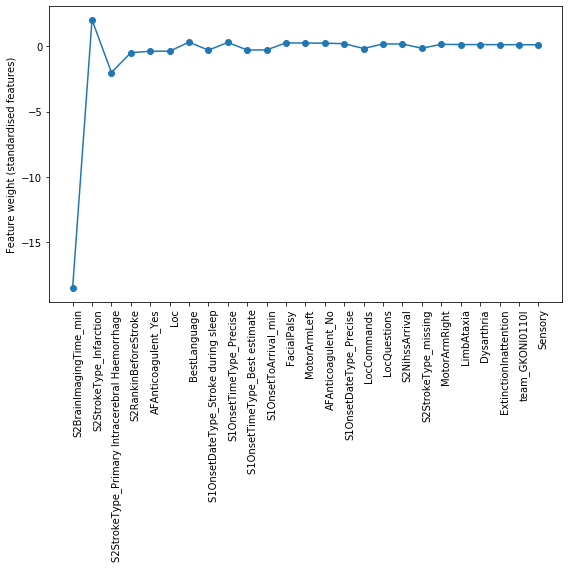

In [22]:
# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = weights.index.values[0:25]
val = weights['weight_mean'].values[0:25]

# Plot
ax.plot(val, marker='o')
ax.set_ylabel('Feature weight (standardised features)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
#plt.savefig('output/lr_single_fit_feature_weights_line.jpg', dpi=300)
plt.savefig('output/lr_single_fit_feature_weights_line.png', dpi=300)
plt.show()

Bar chart:

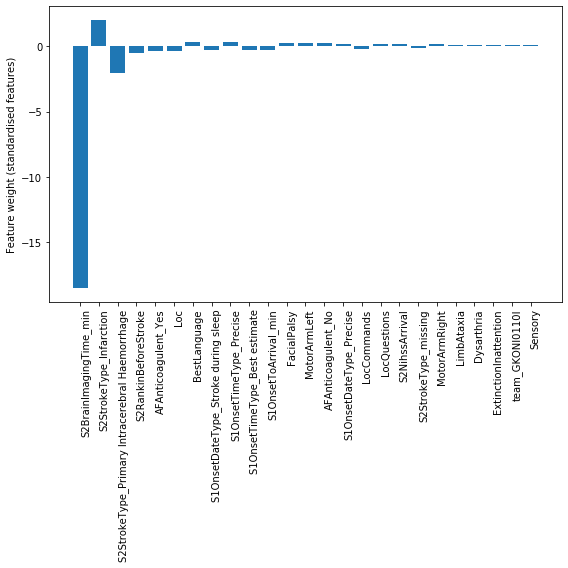

In [23]:
# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = weights.index.values[0:25]
pos = np.arange(len(labels))
val = weights['weight_mean'].values[0:25]

# Plot
ax.bar(pos, val)
ax.set_ylabel('Feature weight (standardised features)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
#plt.savefig('output/lr_single_fit_feature_weights_bar.jpg', dpi=300)
plt.savefig('output/lr_single_fit_feature_weights_bar.png', dpi=300)
plt.show()

## Learning curve

Examine the relationship between training data size and accuracy.

In [24]:
# Set up list to collect results
results_training_size = []
results_accuracy = []
results_all_accuracy = []

# Get maximum training size (number of training records)
max_training_size = train_data[0].shape[0]

# Construct training sizes (values closer at lower end)
train_sizes = [50, 100, 250, 500, 1000, 2500]
for i in range (5000, max_training_size, 5000):
    train_sizes.append(i)

# Loop through training sizes
for train_size in train_sizes:
    
    # Record accuracy across k-fold replicates
    replicate_accuracy = []

    for replicate in range(5):
        
        # Get training and test data (from first k-fold split)
        train = train_data[0]
        test = test_data[0]
        
        # One hot encode hospitals
        train_hosp = pd.get_dummies(train['StrokeTeam'], prefix = 'team')
        train = pd.concat([train, train_hosp], axis=1)
        train.drop('StrokeTeam', axis=1, inplace=True)
        test_hosp = pd.get_dummies(test['StrokeTeam'], prefix = 'team')
        test = pd.concat([test, test_hosp], axis=1)
        test.drop('StrokeTeam', axis=1, inplace=True) 
        
        # Sample from training data
        train = train.sample(n=train_size)

        # Get X and y
        X_train = train.drop('S2Thrombolysis', axis=1)
        X_test = test.drop('S2Thrombolysis', axis=1)
        y_train = train['S2Thrombolysis']
        y_test = test['S2Thrombolysis']        
   
        # Standardise X data
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Define and Fit model
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train_std, y_train)

        # Predict test set
        y_pred_test = model.predict(X_test_std)

        # Get accuracy and record results
        accuracy = np.mean(y_pred_test == y_test)
        replicate_accuracy.append(accuracy)
        results_all_accuracy.append(accuracy)
    
    # Store mean accuracy across the k-fold splits
    results_accuracy.append(np.mean(replicate_accuracy))
    results_training_size.append(train_size)
    
k_fold_accuracy = np.array(results_all_accuracy).reshape(len(train_sizes), 5)

Plot learning curve

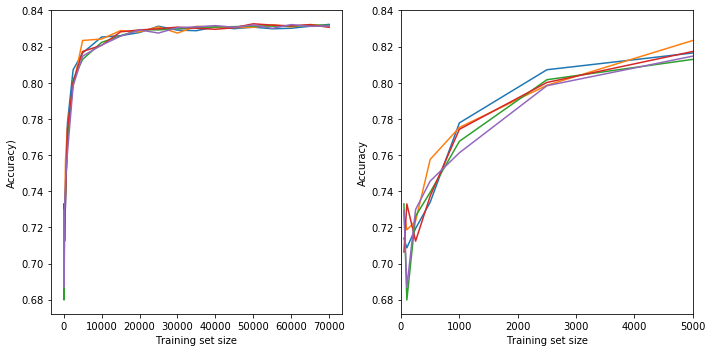

In [25]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)

for i in range(5):
    ax1.plot(results_training_size, k_fold_accuracy[:, i])

ax1.set_xlabel('Training set size')
ax1.set_ylabel('Accuracy)')

# Focus on first 5000
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(results_training_size, k_fold_accuracy[:, i])

ax2.set_xlabel('Training set size')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, 5000)

plt.tight_layout()
plt.savefig('./output/lr_single_learning_curve.png', dpi=300)
plt.show()

## Calibration and assessment of accuracy when model has high confidence

In [26]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for i in range(5):
    
    # Get observed class and predicted probability
    obs = observed[i]
    prob = predicted_proba[i]
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(prob, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = prob
    reliability['observed'] = obs
    classification = 1 * (prob > 0.5 )
    reliability['correct'] = obs == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = i

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

Reliability summary

Plot results

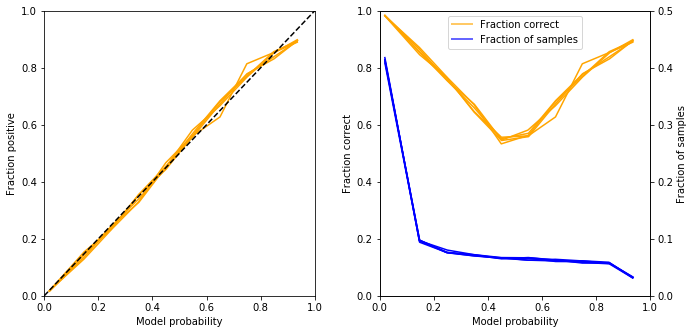

In [27]:
fig = plt.figure(figsize=(10,5))


# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)
plt.savefig('./output/lr_single_reliability.png', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [28]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

For samples with at least 80% confidence:
Proportion of all samples: 0.599
Accuracy: 0.896


## Observations (of the original notebook)

* Overall accuracy = 83.2% (89.6% for those 60% samples with at least 80% confidence of model)
* Using nominal threshold (50% probability), specificity (88%) is greater than sensitivity (72%)
* The model can achieve 82.0% sensitivity and specificity simultaneously
* ROC AUC = 0.904
* Only marginal improvements are made above a training set size of 20k
* Key features predicting use of thrombolysis are:
    * Time from arrival to scan
    * Stroke type
    * Disability before stroke
    * Presence of AFAnticoagulent_Yes
    * Level of consciousness
* The model shows good calibration of probability vs. fraction positive, without need of additional calibration

## Onwards is the extension of the original notebook.

## Shapley values

Get Shapley values for the Logistic Regression (average across k-fold results) for training set.
Sort by absolute value.

Calculate Shapley Value (one per feature) for each of the k-fold models, using the average across all instances.
Store the Shapley Values (one per feature for each k-fold) in a list. Also store the standard deviation.

In [29]:
shap_value_mean = []
shap_value_std = []

# calculate mean of all the instances, to get a shapley value for each feature for each kfold

for kfold in range(5):
    shap_value_mean.append(np.array(shap_values_train[kfold]).mean(axis = 0))
    shap_value_std.append(np.array(shap_values_train[kfold]).std(axis = 0))
    
# shap_value_mean has length 5. 
# shap_value_mean[0] has the shapley values for the individual features for k-fold 0 (taking a mean across all of the instances)
# shap_value_mean[1] has the shapley values for the individual features for k-fold 1 (taking a mean across all of the instances)

Now calculate a Shapley Value for each feature by taking the mean across the 5 k-folds (so a mean of the means). Obtain a single shapley value for each feature.

In [30]:
features = X_test.columns.values

#number of values contributing to the mean calculation
n = len(feature_weights)

# Get average feature importance from k-fold
s_values_train = np.array(shap_value_mean).mean(axis = 0)
s_values_train = pd.DataFrame(data = s_values_train, index=features)
s_values_train.columns = ['shap_values_mean']
s_values_train['shap_values_std_dev'] = np.array(shap_value_mean).std(axis = 0)
s_values_train['shap_values_std_error'] = s_values_train['shap_values_std_dev']/math.sqrt(n)
s_values_train['s_values_mean_abs'] = abs(s_values_train['shap_values_mean'])

# Sort by importance (shap_values_mean_abs)
s_values_train.sort_values(by='s_values_mean_abs', ascending=False, inplace=True)

# Save
s_values_train.to_csv('output/lr_single_fit_shapley_values_train.csv')

# Display top 25
s_values_train.head(25)

,shap_values_mean,shap_values_std_dev,shap_values_std_error,s_values_mean_abs
S2BrainImagingTime_min,-1.151812,0.159777,0.071454,1.151812
S2StrokeType_Primary Intracerebral Haemorrhage,0.289229,0.063968,0.028607,0.289229
S2StrokeType_Infarction,0.280620,0.062245,0.027837,0.280620
AFAnticoagulent_Yes,-0.032469,0.022314,0.009979,0.032469
BestLanguage,0.022754,0.014666,0.006559,0.022754
S1OnsetToArrival_min,0.020549,0.031919,0.014275,0.020549
team_ZBVSO0975W,0.020479,0.010698,0.004785,0.020479
Loc,-0.017495,0.019898,0.008899,0.017495
LocQuestions,0.016066,0.008162,0.003650,0.016066
team_LECHF1024T,0.014270,0.009192,0.004111,0.014270


The feature S2BrainImagingTime_min is an outlier for both feature weights and shapley values.

S2BrainImagingTime_min has a Shapley Value of -1.151812, when the rest of the features are in the range of -0.03 to 0.289.

## Plot mean Shapley Value vs mean Feature Weight
Include an error bar showing the standard error (SD / root(n))

In [31]:
# join the two sets of data (shapley value, and feature weight) in a single dataframe based on the feature

shap_and_weights_df = pd.concat([s_values_train['shap_values_mean'], weights['weight_mean'],
                                 s_values_train['shap_values_std_error'], weights['weight_std_error']], 
                                 axis=1)

In [32]:
def plot_scatter_with_error_bars(df):
    # plot data

    # Set up figure
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    # Plot points
    x = df['shap_values_mean']
    y = df['weight_mean']
    ax.scatter(x, y)

    # Plot error bars
    x_err = df['shap_values_std_error']
    y_err = df['weight_std_error']
    ## you can use color ="r" for red or skip to default as blue
    plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt="o")#, color="r")

    ax.set_title('Shapley value vs. Feature weight for each feature')
    ax.set_xlabel('Shapley value')
    ax.set_ylabel('Feature weight')  

    plt.tight_layout()
    #plt.savefig('output/lr_single_fit_feature_weights_bar.jpg', dpi=300)
    plt.savefig('output/lr_single_fit_feature_weights_vs_shapley_values.png', dpi=300)
    plt.show()
    
    return()

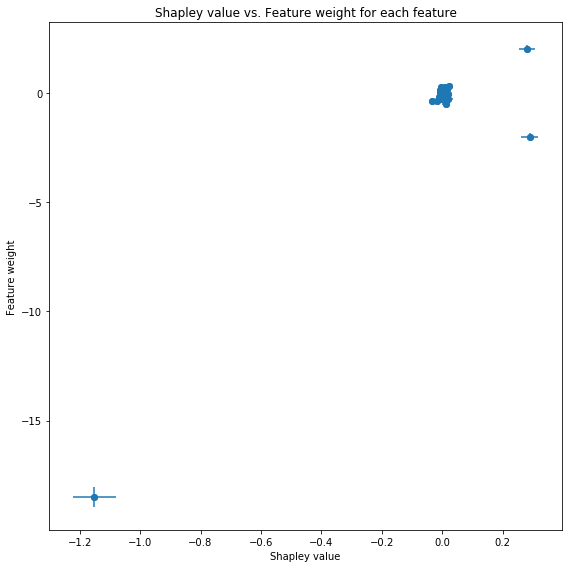

()

In [33]:
plot_scatter_with_error_bars(shap_and_weights_df)

Remove any features that are an outlier. For this case, remove 'S2BrainImagingTime_min'

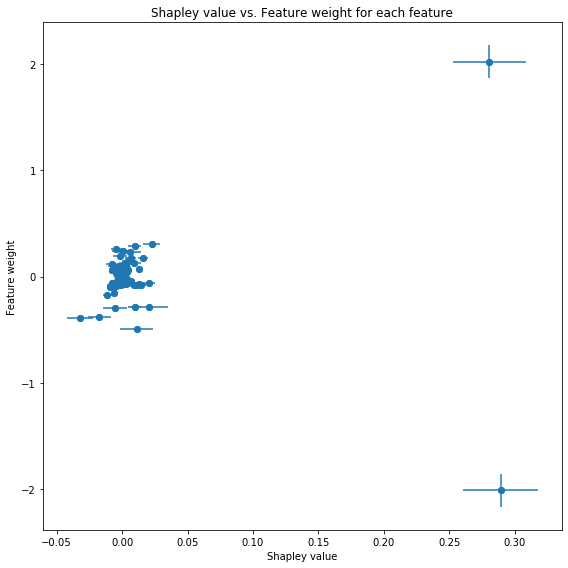

()

In [34]:
shap_and_weights_df_mod = shap_and_weights_df.drop('S2BrainImagingTime_min')
plot_scatter_with_error_bars(shap_and_weights_df_mod)

Remove any more features that are an outlier. In this case remove any features that have a feature weight outside -1 to 1, or above 1 for shapley value

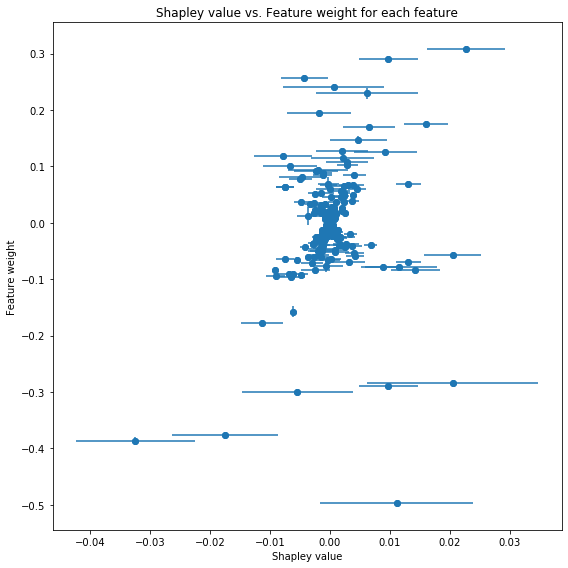

()

In [35]:
mask = ((shap_and_weights_df_mod["weight_mean"] > -1) & 
        (shap_and_weights_df_mod["weight_mean"] < 1))
shap_and_weights_df_mod = shap_and_weights_df_mod[mask]

mask = shap_and_weights_df_mod["shap_values_mean"] < 1
shap_and_weights_df_mod = shap_and_weights_df_mod[mask]

plot_scatter_with_error_bars(shap_and_weights_df_mod)

## 1. Show the top 10 (absolute value) Shapley values and Feature weights

In [36]:
shap_and_weights_df['shap_values_mean_abs'] = shap_and_weights_df['shap_values_mean'].abs()
shap_and_weights_df = shap_and_weights_df.sort_values(by=['shap_values_mean_abs'], ascending=False)
shap_and_weights_10_df = pd.DataFrame(data = shap_and_weights_df.index[0:10], 
                                      columns = ['absolute shapley values ranked'])

shap_and_weights_df['weight_mean_abs'] = shap_and_weights_df['weight_mean'].abs() 
shap_and_weights_df = shap_and_weights_df.sort_values(by=['weight_mean_abs'], ascending=False)
shap_and_weights_10_df['absolute feature weights ranked'] = shap_and_weights_df.index[0:10]

shap_and_weights_10_df

,absolute shapley values ranked,absolute feature weights ranked
0,S2BrainImagingTime_min,S2BrainImagingTime_min
1,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_Infarction
2,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage
3,AFAnticoagulent_Yes,S2RankinBeforeStroke
4,BestLanguage,AFAnticoagulent_Yes
5,S1OnsetToArrival_min,Loc
6,team_ZBVSO0975W,BestLanguage
7,Loc,S1OnsetDateType_Stroke during sleep
8,LocQuestions,S1OnsetTimeType_Precise
9,team_LECHF1024T,S1OnsetTimeType_Best estimate


# Part 2: Fit a logistic regresion model on all of the data (create SHAP plots)

Do not split the data into a train/test split. Use all the data to fit a logistic regression model, and recalculate the Shapley values and model weights

To get all of the instances, use one of the k-fold splits and combine the train and test into one dataset. Then refit the model and analyse the parameters.

In [37]:
# Combine train and test for k fold 0 split
chosen_k_fold = 0

train_test = pd.concat([train_data[chosen_k_fold],
                        test_data[chosen_k_fold]])

# Get X and y
X = train_test.drop('S2Thrombolysis', axis=1)
y = train_test['S2Thrombolysis']

# One hot encode hospitals
X_hosp = pd.get_dummies(X['StrokeTeam'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('StrokeTeam', axis=1, inplace=True)

# Standardise X data 
# (function requires train and test set, so pass X in twice and discard the second returned argument)
X_std, discard = standardise_data(X, X)

# The above function (standardise_data) returns a numpy array. 
# Using X_std in the SHAP plots means no feature names are used on the plot
# To get feature names to appear on the plots, save the numpy array as a pandas Dataframe (with feature names as columns)
X_std_df = pd.DataFrame(X_std, columns=X.columns)

# Define and Fit model
model = LogisticRegression(solver='lbfgs')
model.fit(X_std, y)

# Get feature weights
weights = model.coef_[0]

# Get predicted probabilities
y_probs = model.predict_proba(X_std)[:,1]

# Calibrate model and get class
true_rate = np.mean(y)
threshold = find_threshold(y_probs, true_rate)
y_class = y_probs >= threshold
y_class = np.array(y_class) * 1.0

# Calculate Shapley values
#(shapley_values, shapley_values_extended) = calculate_shapley_values(model, X_std)
(shapley_values_df, shapley_values_extended_df) = calculate_shapley_values(model, X_std_df)

# this next line of code is in the function above (calculate_shapley_values), but we need to use "explainer" for the waterfall plot, and so we need i to be available in the main code.
# Tidy this up later, just put it here too so that the code can run
#explainer = shap.Explainer(model, X_std)

# Print accuracy
accuracy = np.mean(y_class == y)
print (
    f'accuracy: {accuracy:0.3f}, threshold {threshold:0.3f}')

accuracy: 0.833, threshold 0.472


#### What's the top 10 features for Shapley value and feature weight for this model?
(I look at this because for the k-fold data, feature "S2BrainImagingTime_min" was an outlier for the global importance, but when looked at individual instances, this feature was often third in importance.

In [38]:
features = X_test.columns.values

# Create a dataframe with shapley values ordered by absolute value
shapley_values_ordered = pd.DataFrame(data = shapley_values_df.mean(axis = 0), index=features)
shapley_values_ordered.columns = ['shap_values_mean']
shapley_values_ordered['s_values_mean_abs'] = abs(shapley_values_ordered['shap_values_mean'])
# Sort by importance (absolute)
shapley_values_ordered.sort_values(by='s_values_mean_abs', ascending=False, inplace=True)

# Create a dataframe with feature weights ordered by absolute value
feature_weights_ordered = pd.DataFrame(data = weights, index=features)
feature_weights_ordered.columns = ['weight_mean']
feature_weights_ordered['weight_mean_abs'] = abs(feature_weights_ordered['weight_mean'])
# Sort by importance (absolute weight)
feature_weights_ordered.sort_values(by='weight_mean_abs', ascending=False, inplace=True)

# Join the results fo teh top 10 shapley value features and top 10 feature weights in a dataframe
shap_and_weights_10_df = pd.DataFrame(data = shapley_values_ordered.index[0:10], 
                                      columns = ['absolute shapley values ranked'])
shap_and_weights_10_df['absolute feature weights ranked'] = feature_weights_ordered.index[0:10]

shap_and_weights_10_df.head(10)

,absolute shapley values ranked,absolute feature weights ranked
0,S2BrainImagingTime_min,S2BrainImagingTime_min
1,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_Infarction
2,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage
3,Loc,S2RankinBeforeStroke
4,AFAnticoagulent_Yes,Loc
5,BestLanguage,AFAnticoagulent_Yes
6,MotorArmLeft,BestLanguage
7,S1OnsetToArrival_min,S1OnsetDateType_Stroke during sleep
8,team_VKKDD9172T,S1OnsetTimeType_Best estimate
9,team_KZKEZ2257Z,S1OnsetTimeType_Precise


## Show a Beeswarm plot for all the data

Using code from 
https://samuel-book.github.io/samuel-1/random_forest/characterise_contentious_patients.html#observations

### Shap bee swarm plot

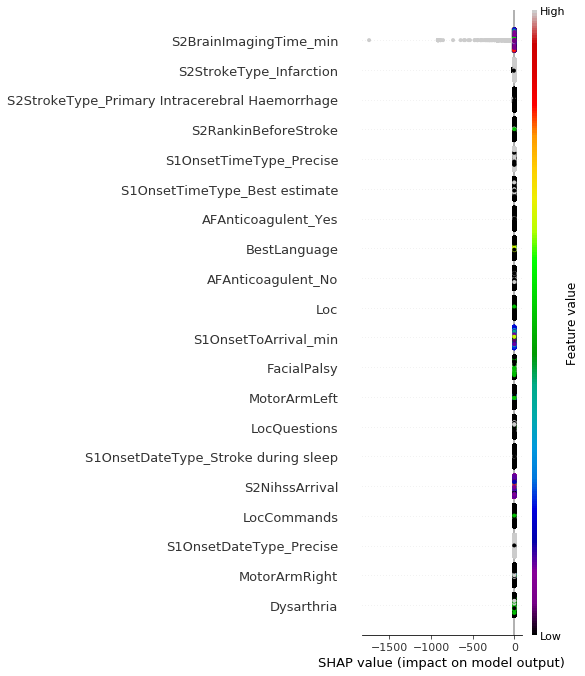

In [39]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_df, 
                  features = X.values,
                  feature_names = X.columns.values, 
                  cmap = plt.get_cmap('nipy_spectral'), 
                  show=False)
plt.tight_layout()

plt.savefig('output/shap_beeswarm.png', dpi=300)

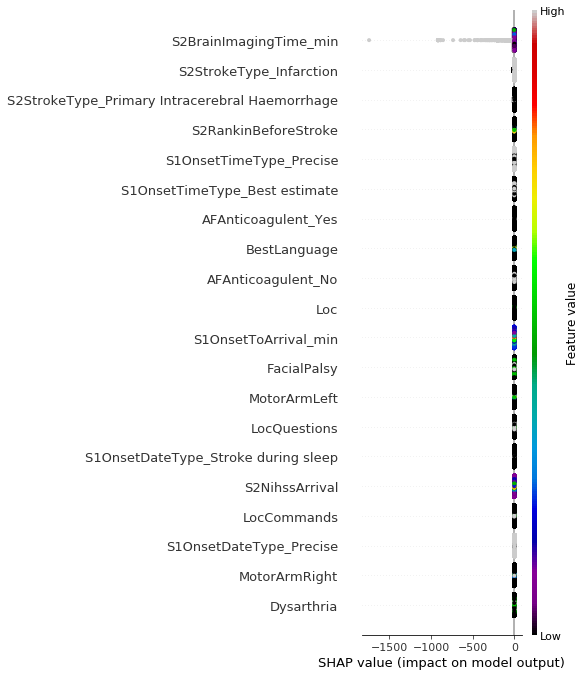

In [40]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_df, 
                  features = X_std_df.values,
                  feature_names = X_std_df.columns.values, 
                  cmap = plt.get_cmap('nipy_spectral'), 
                  show=False)
plt.tight_layout()

plt.savefig('output/shap_beeswarm.png', dpi=300)

Remove the outlier S2BrainImagingTime_min, and replot the beeswarm

In [41]:
X_mod = X.drop("S2BrainImagingTime_min", axis=1)
shapley_values_mod = np.delete(shapley_values_df, X.columns.get_loc("S2BrainImagingTime_min"), 1)

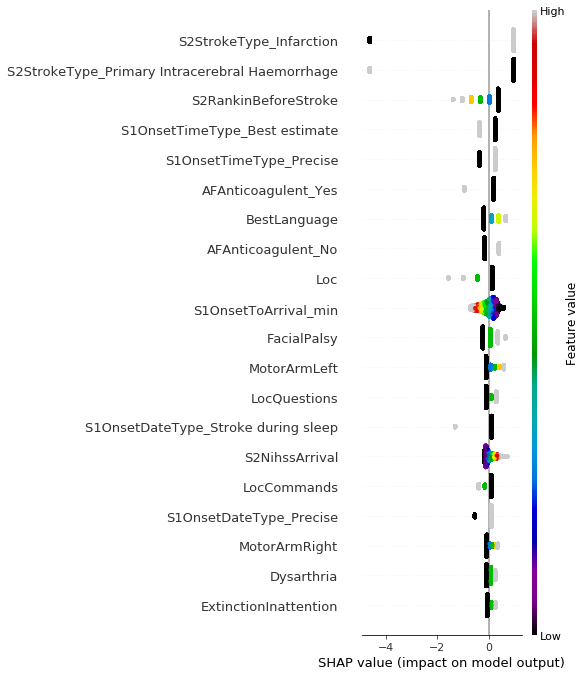

In [42]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_mod, 
                  features = X_mod.values,
                  feature_names = X_mod.columns.values, 
                  cmap = plt.get_cmap('nipy_spectral'), show=False)
plt.tight_layout()

plt.savefig('output/shap_beeswarm.png', dpi=300)

## Plot Waterfall plots for three instances: 
An example with a low probability of giving thrombolysis, one with a probability close to 0.5, and one with a high probability of giving thrombolysis. 

Use code for waterfall from 05_keras_tabular-waterfall.ipynb

(If possible, plot in a single wide MatPlotLib plot) 

Identify three instances, to cover the range for y_probs: 0, 0.5, 1.
Take the first occurance that satisfies the criteria (by using "[0][0]")

In [43]:
location_low_probability = np.where(y_probs < 0.01)[0][0]
location_middle_probability = np.where((y_probs > 0.49) & (y_probs < 0.51))[0][0]
location_high_probability = np.where(y_probs > 0.99)[0][0]

#### Waterfall plot for low probability of thrombolysis (showing log-odds)

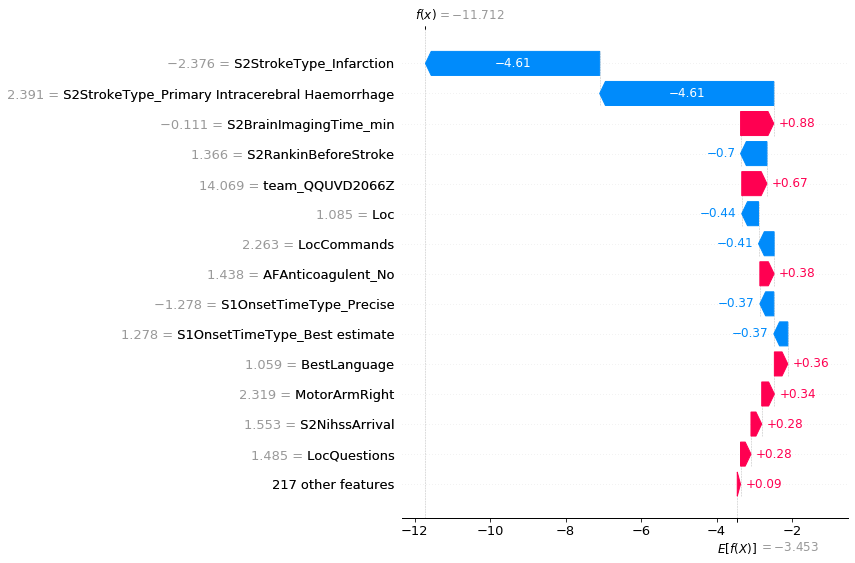

In [44]:
shap.plots.waterfall(shapley_values_extended_df[location_low_probability], 
                     max_display=15)

#### Waterfall plots (showing log-odds), one for each instance (low, middle, high change for thrombolysis)

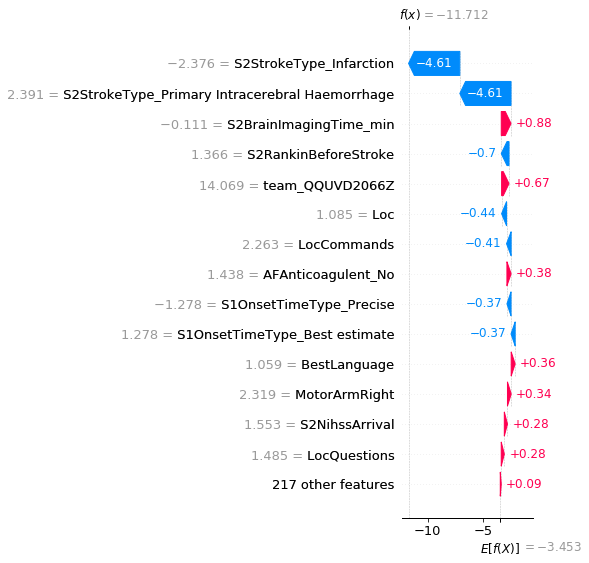

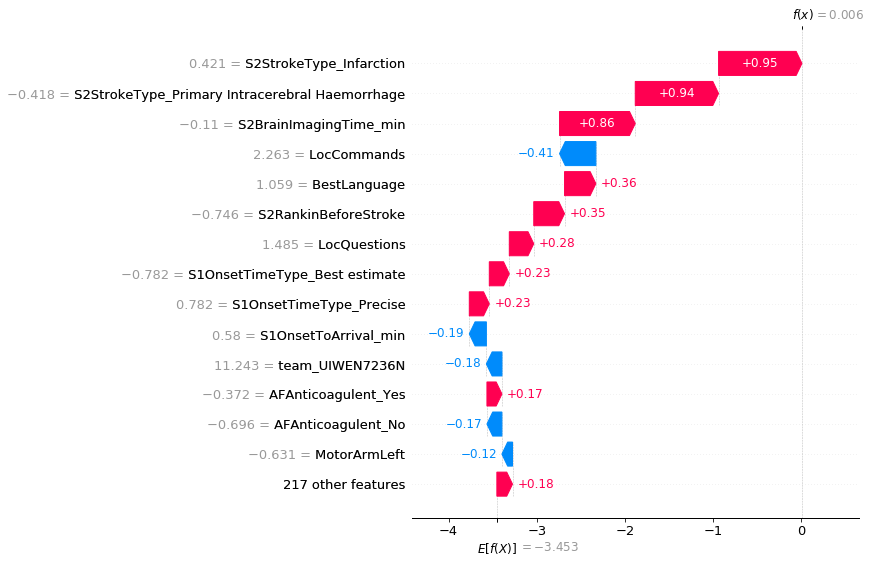

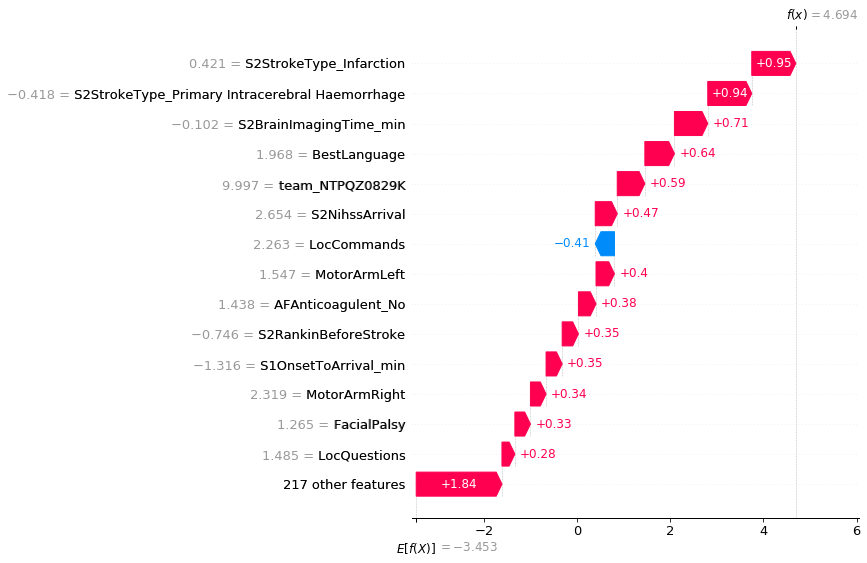

<Figure size 432x288 with 0 Axes>

In [45]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(131)
shap.plots.waterfall(shapley_values_extended_df[location_low_probability], max_display=15)#, show=False)
ax1.title.set_text('Low thrombolysis probability')

ax2 = fig.add_subplot(132)
shap.plots.waterfall(shapley_values_extended_df[location_middle_probability], max_display=15)#, show=False)
ax2.title.set_text('Medium thrombolysis probability')

ax3 = fig.add_subplot(133)
shap.plots.waterfall(shapley_values_extended_df[location_high_probability], max_display=15)#, show=False)
ax3.title.set_text('High thrombolysis probability')

fig.set_figheight(10)
fig.set_figwidth(50)

plt.tight_layout()
plt.show()

(using content from "https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c")

By default, SHAP explains models in terms of their margin output before the logistic link function [https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html], hence the x axis units in the waterfall plot are log-odds units, and not probability.

You can convert the log-odd to a probability of [0,1] by using the logistic sigmoid function, which is expit(x) = 1/(1+exp(-x)), the inverse of the logit function. In other words, 1(1+exp(-4.894) ) = 0.992. 
Here's a utility function that does the conversion from the log-odds to probabilities (with thanks for Dataman in AI). 

In [46]:
def shap_transform_scale(original_shap_values, Y_pred, which):
    
    #Compute the transformed base value, which consists in applying the logit function to the base value
    from scipy.special import expit #Importing the logit function for the base value transformation
    untransformed_base_value = original_shap_values.base_values[-1]
   
    #Computing the original_explanation_distance to construct the distance_coefficient later on
    original_explanation_distance = np.sum(original_shap_values.values, axis=1)[which]
    
    base_value = expit(untransformed_base_value ) # = 1 / (1+ np.exp(-untransformed_base_value))

    #Computing the distance between the model_prediction and the transformed base_value
    distance_to_explain = Y_pred[which] - base_value

    #The distance_coefficient is the ratio between both distances which will be used later on
    distance_coefficient = original_explanation_distance / distance_to_explain

    #Transforming the original shapley values to the new scale
    shap_values_transformed = original_shap_values / distance_coefficient

    #Finally resetting the base_value as it does not need to be transformed
    shap_values_transformed.base_values = base_value
    shap_values_transformed.data = original_shap_values.data
    
    #Now returning the transformed array
    return shap_values_transformed    


Let’s apply the conversion, then do the waterfall plots

#### Waterfall plot for low probability of thrombolysis (showing probability)

The prediction is  8.194756384009906e-06


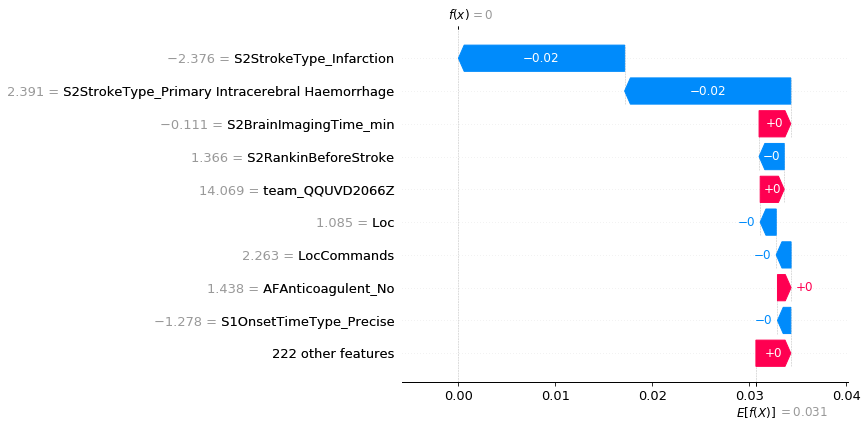

In [47]:
print("The prediction is ", y_probs[location_low_probability])
shap_values_transformed = shap_transform_scale(shapley_values_extended_df, y_probs, location_low_probability)
shap.plots.waterfall(shap_values_transformed[location_low_probability])

#### Waterfall plots (showing probability), one for each instance (low, middle, high chance for thrombolysis)

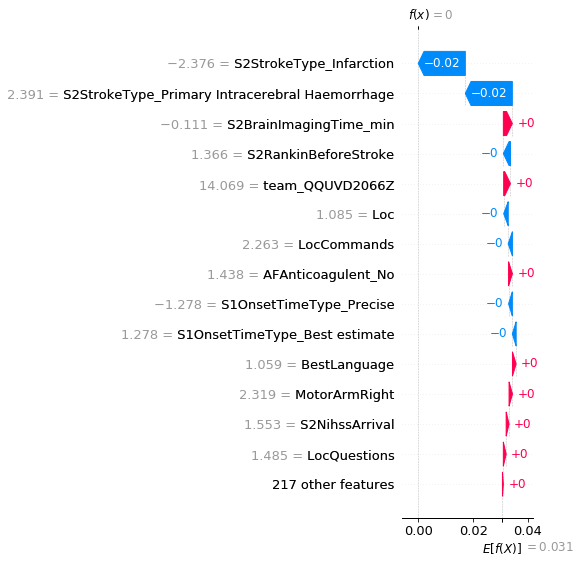

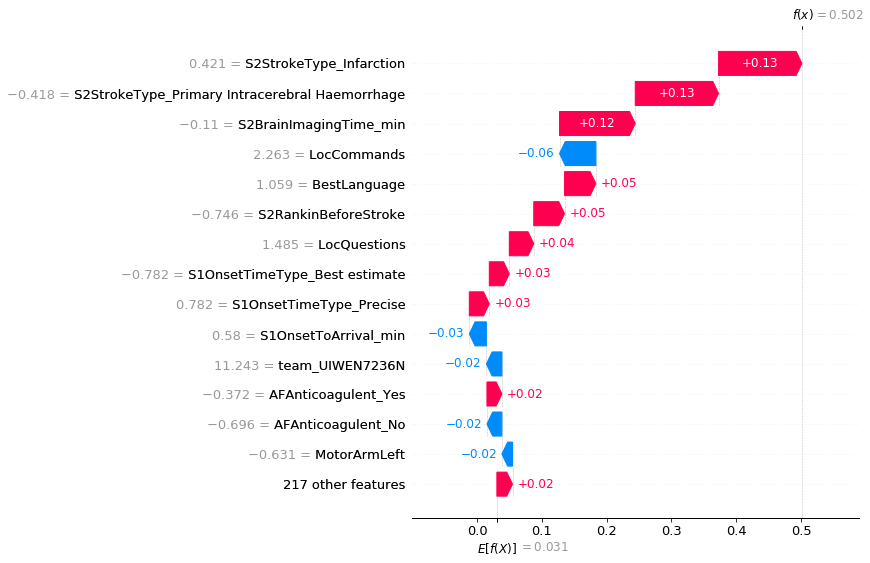

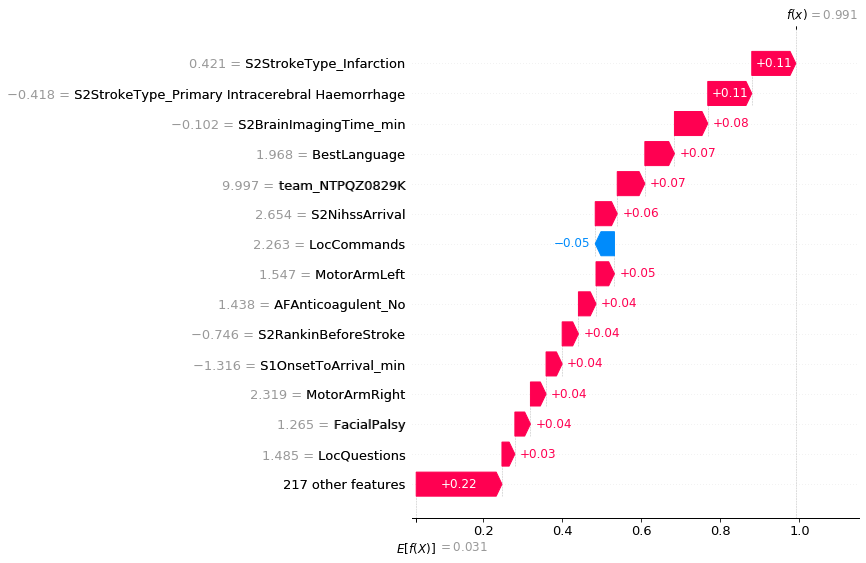

<Figure size 432x288 with 0 Axes>

In [48]:
fig = plt.figure(figsize=(10,5))

expected_value = shapley_values_extended_df.base_values[0]

ax1 = fig.add_subplot(131)
shap_values_transformed = shap_transform_scale(shapley_values_extended_df, y_probs, location_low_probability)
shap.plots.waterfall(shap_values_transformed[location_low_probability], max_display=15)#, show=False)
ax1.title.set_text('Low thrombolysis probability')

ax2 = fig.add_subplot(132)
shap_values_transformed = shap_transform_scale(shapley_values_extended_df, y_probs, location_middle_probability)
shap.plots.waterfall(shap_values_transformed[location_middle_probability], max_display=15)#, show=False)
ax2.title.set_text('Medium thrombolysis probability')

ax3 = fig.add_subplot(133)
shap_values_transformed = shap_transform_scale(shapley_values_extended_df, y_probs, location_high_probability)
shap.plots.waterfall(shap_values_transformed[location_high_probability], max_display=15)#, show=False)
ax3.title.set_text('High thrombolysis probability')

#fig.set_figheight(15)
fig.set_figwidth(25)

plt.tight_layout()
plt.show()

## Decision plots showing log-odds

### For low probability thrombolysis

The expected value is -3.4527036151207966
Chart is dislaying in brackets the raw (not standardised) feature values (model was trained on standardised values)


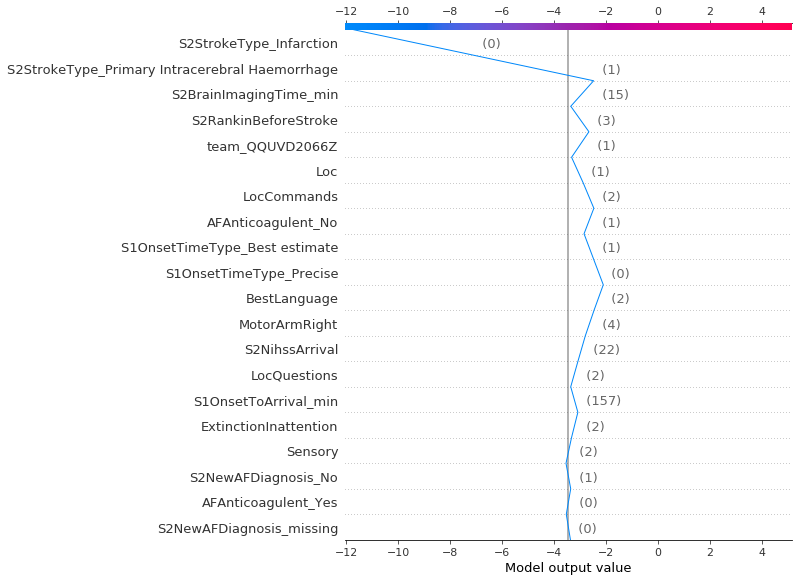

In [49]:
instance = location_low_probability

chosen_instance = X.iloc[instance] #used for the feature value (in brackets on graph)
shap_values_instance = shapley_values_df[instance] #used for charted value
expected_value = shapley_values_extended_df.base_values[0]#explainer.expected_value #The starting point
print(f"The expected value is {expected_value}")
print(f"Chart is dislaying in brackets the raw (not standardised) feature values (model was trained on standardised values)")

shap.decision_plot(expected_value, shap_values_instance, chosen_instance)

The expected value is -3.4527036151207966
Chart is dislaying in brackets the standardised feature values (model was trained on standardised values)


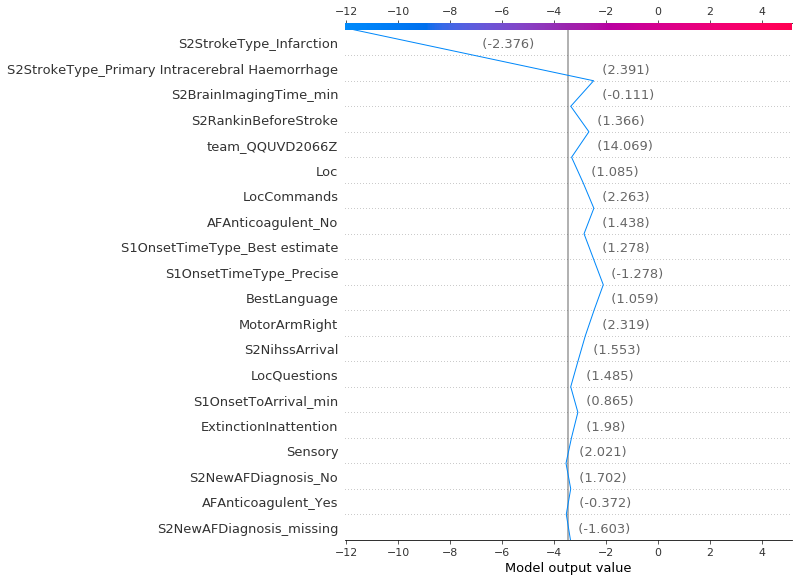

In [50]:
instance = location_low_probability

chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shapley_values_df[instance]
expected_value = shapley_values_extended_df.base_values[0]#explainer.expected_value
print(f"The expected value is {expected_value}")
print(f"Chart is dislaying in brackets the standardised feature values (model was trained on standardised values)")

shap.decision_plot(expected_value, shap_values_instance, chosen_instance)

### Decision plots showing three instances on a subplot (log-odds)

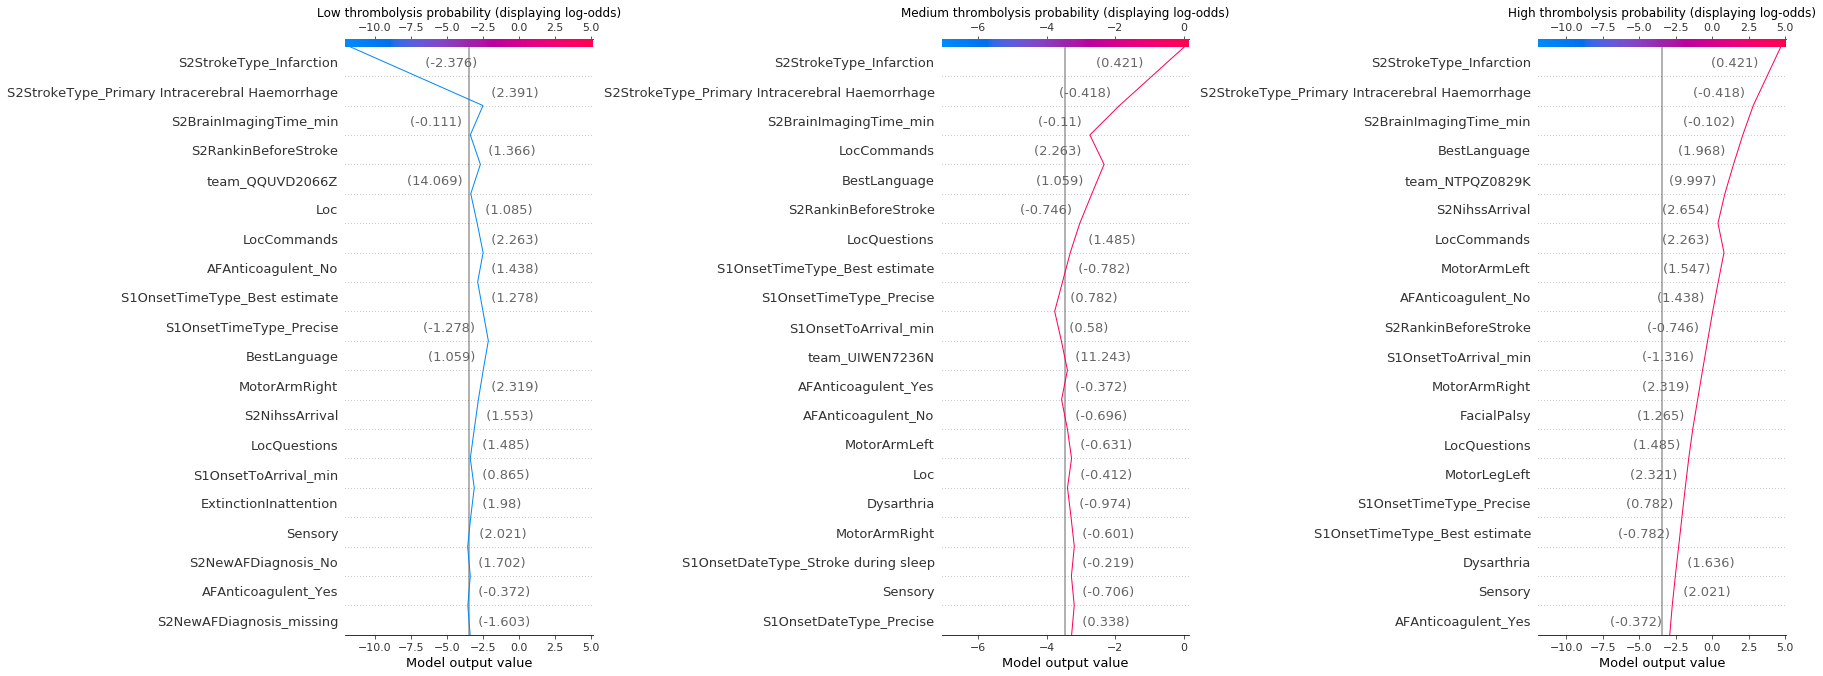

In [51]:
fig = plt.figure(figsize=(10,5))

expected_value = shapley_values_extended_df.base_values[0]#explainer.expected_value

ax1 = fig.add_subplot(131)
instance = location_low_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shapley_values_df[instance]
shap.decision_plot(expected_value, shap_values_instance, chosen_instance, show=False)
ax1.title.set_text('Low thrombolysis probability (displaying log-odds)')

ax2 = fig.add_subplot(132)
instance = location_middle_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shapley_values_df[instance]
shap.decision_plot(expected_value, shap_values_instance, chosen_instance, show=False)
ax2.title.set_text('Medium thrombolysis probability (displaying log-odds)')

ax3 = fig.add_subplot(133)
instance = location_high_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shapley_values_df[instance]
shap.decision_plot(expected_value, shap_values_instance, chosen_instance, show=False)
ax3.title.set_text('High thrombolysis probability (displaying log-odds)')

#fig.set_figheight(15)
fig.set_figwidth(25)

plt.tight_layout()
plt.show()

### Decision plots showing three instances on a subplot (probability)

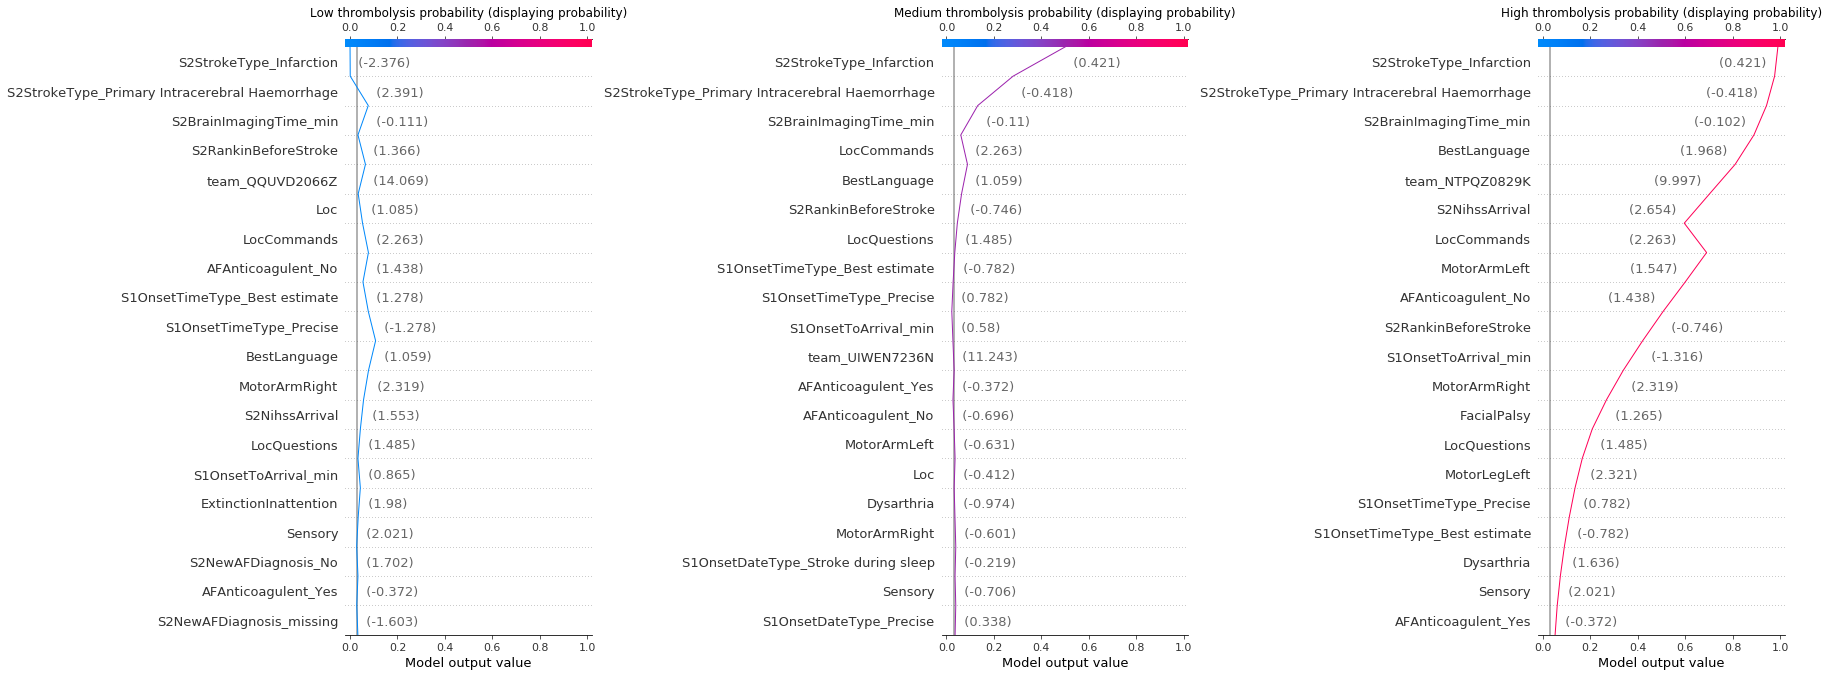

In [52]:
fig = plt.figure(figsize=(10,5))

expected_value = shapley_values_extended_df.base_values[0]#explainer.expected_value

ax1 = fig.add_subplot(131)
instance = location_low_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shapley_values_df[instance]
shap.decision_plot(expected_value, shap_values_instance, chosen_instance, link='logit',show=False)
ax1.title.set_text('Low thrombolysis probability (displaying probability)')

ax2 = fig.add_subplot(132)
instance = location_middle_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shapley_values_df[instance]
shap.decision_plot(expected_value, shap_values_instance, chosen_instance, link='logit', show=False)
ax2.title.set_text('Medium thrombolysis probability (displaying probability)')

ax3 = fig.add_subplot(133)
instance = location_high_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shapley_values_df[instance]
shap.decision_plot(expected_value, shap_values_instance, chosen_instance, link='logit', show=False)
ax3.title.set_text('High thrombolysis probability (displaying probability)')

#fig.set_figheight(15)
fig.set_figwidth(25)

plt.tight_layout()
plt.show()

#### Included this for completeness, using the same method for the Waterfall plots to transform the log-odds to probability

The prediction is  8.194756384009906e-06
The expected value is 0.03068833398274737


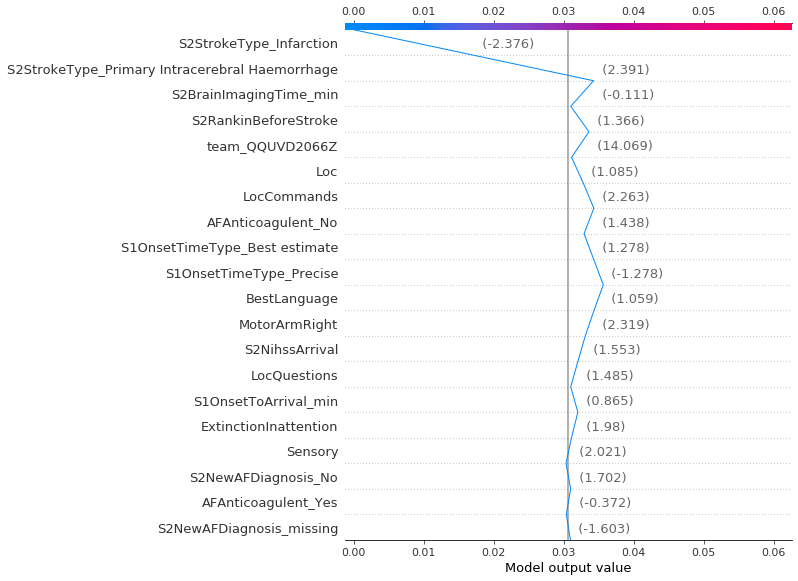

In [53]:
instance_location = location_low_probability

print("The prediction is ", y_probs[instance_location])

shap_values_transformed = shap_transform_scale(shapley_values_extended_df, y_probs, instance_location)
shap_values_transformed_instance = shap_values_transformed[instance_location]

chosen_instance = X_std_df.iloc[instance_location]

expected_value = shap_values_transformed.base_values
print(f"The expected value is {expected_value}")

shap.decision_plot(expected_value, shap_values_transformed_instance.values, chosen_instance)

# (1) Global Interpretability
## (1.1) Bar plot for feature importance

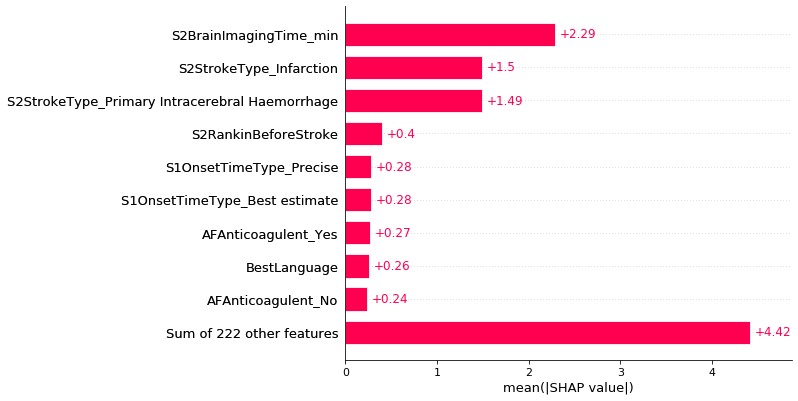

In [54]:
shap.plots.bar(shapley_values_extended_df, max_display=10) # default is max_display=12

## (1.2) Cohort plot

Get an error when I run this code. I believe it is an error within the ".cohorts()" procedure as I can replicate the error just running "shapley_values_extended_df.cohorts(2)".

Change the cell below from Markdown to Code to work on it.

shap.plots.bar(shapley_values_extended_df.cohorts(2).abs.mean(0))

## (1.3) Heatmap plot

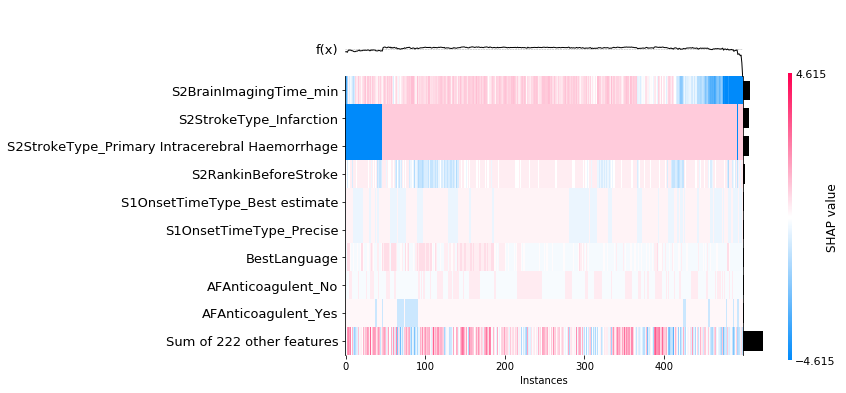

In [55]:
shap.plots.heatmap(shapley_values_extended_df[0:500])

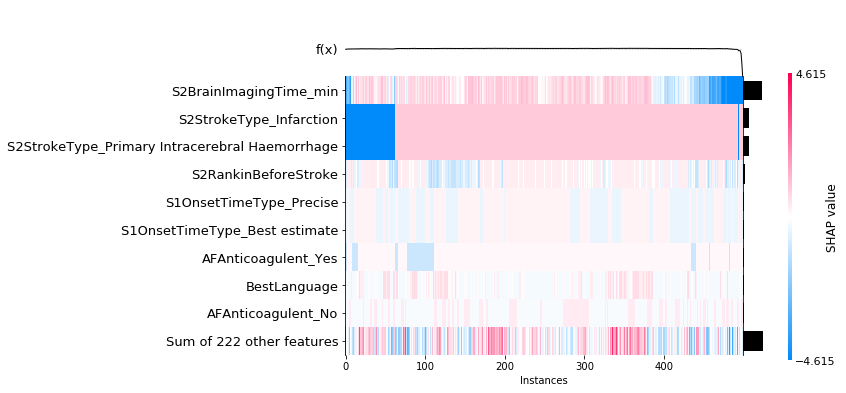

In [56]:
shap.plots.heatmap(shapley_values_extended_df[500:1000])

# (2) Local Interpretability

## (2.1) Waterfall plots (see earlier section)

## (2.2) The bar plot for an individual case

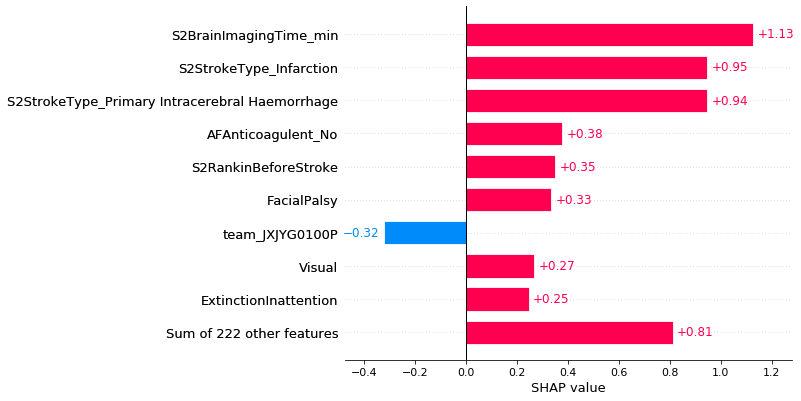

In [57]:
shap.plots.bar(shapley_values_extended_df[0]) # For the first observation

In [58]:
## (2.3) Decision plots (see earlier section)

### This next section is now redundant. It was coded Waterfall plot, as I couldn't get the waterfall plot to include the Feature Names on the y axis. Thought that this was a issue for logistic regression shapley values. In fact it was because the standardise fuction returned a numpy array for X_train_std. The function needed a dataframe in order to use the column values for the chart. So I saved the X_train_std as a dataframe and the feature names now exist on the charts.

******************************************

## 2. Plotting waterfall using own code

## Code to create waterfall plot for shapley values as calculated by DeepExplainer (from the SHAP library)

We will use the data as calculated in the previous code cell. This is data for a single instance:

1) chosen_instance = X.iloc[instance]
2) shap_values_instance = shapley_values[instance]
3) explainer.expected_value

In addition to the variables set up above (choosen_instance, shap_values_instance, expected_value), we also want the predicted output value from the model. Use this to compare with the culmulative sum of the shapley value.

Import libraries

In [59]:
import matplotlib.patches as mpatches

Define function to create waterfall plot

In [60]:
def waterfall_plot(chosen_instance, shap_values_instance, expected_value, 
                   predicted_value, max_display=-1, style_arrows=False):
    """
    NEED TO IMPROVE THIS FUNCTION SO THAT LABEL PLACEMENT ON THE PLOT, AND PLOT SIZE ADJUSTMENT WORKS FOR ALL PLOT SIZES
    AT THE MOMENT, I AM CUSTOMISING THE ADJUSTMENTS FOR EACH GRAPH.
    THE CODE THAT NEEDS ADJUSTING IS MARKED WITH #***
    
    chosen_instance: [pandas dataframe] the index is feature name, value is 
                     feature value for instance
    shap_values_instance: [numpy array] the shapley values for each feature for 
                          the instance
    expected_value: [float] the output value that is expected for the dataset 
                    (e.g. median)
    predicted_value: [float] the predicted output for the instance
    max_display: [integer] the number of features to include in the waterfall
                  plot. If nothing is passed, all features are plotted
    style_arrows: [boolean] whether to display as a horizontal bar chart 
                  (False), or using arrows (True)
    
    """
    
    # set up pandas dataframe with the data required for the waterfall chart
    data = pd.DataFrame(chosen_instance)
    data.columns = ["instance"]
    data["shap"] = shap_values_instance
    data["shap_absolute"] = np.abs(shap_values_instance)
    
    # limit the number of features to display to the number available
    max_display = min(max_display, data.shape[0])

    # if max_display not passed, set to total number of features available
    if max_display == -1:
        max_display = data.shape[0]
        
    # sort the rows on the absolute shapley values (smallest value at top)
    data = data.sort_values(by=["shap_absolute"], 
                                      ascending=True)

    # if want to display fewer features than the full set
    if max_display < data.shape[0]:

        # select features ranked by most influence
        waterfall_plot = data.tail(max_display)    

        # represent the remaining features as one row
        waterfall_plot_remaining = data.iloc[0:-max_display]
        summary_remaining = pd.DataFrame(
                                    columns=waterfall_plot_remaining.columns)
        summary_remaining["instance"] = [np.nan]
        summary_remaining["shap"] = [waterfall_plot_remaining.shap.sum()]
        summary_remaining["shap_absolute"] = (
                                [np.abs(waterfall_plot_remaining.shap.sum())])
        index_title = f"remaining_{waterfall_plot_remaining.shape[0]}_features"
        summary_remaining.index = [index_title]
        waterfall_plot = summary_remaining.append(waterfall_plot)

    else:
        waterfall_plot = data.copy(deep=True)
        
    # create two new columns containing the x coordinates for the lhs and rhs of
    # each bar    
    # one side of the first bar is the expected value plus the bar's shapley 
    # value. The remaining bars take as one side the culmulative sum of the
    # shapley values and the expected value.
    shap_series = waterfall_plot.shap.copy(deep=True)
    shap_series[0] = shap_series[0] + expected_value#explainer.expected_value
    shap_cumsum = shap_series.cumsum()

    # the other side of each bar is the value from the previous bar (for the 
    # first bar, this is the expected value)
    shap_cumsum_prev = shap_cumsum.copy(deep=True)
    shap_cumsum_prev[1:] = shap_cumsum_prev[0:-1]
    shap_cumsum_prev[0] = expected_value#explainer.expected_value

    # the shapley values can be either sign, so the LHS is the min of both
    # series, and the RHS is the max of both series
    # add these to the waterfall_plot DataFrame
    lhs_bar = pd.DataFrame([shap_cumsum_prev, shap_cumsum]).min()
    rhs_bar = pd.DataFrame([shap_cumsum_prev, shap_cumsum]).max()
    waterfall_plot["lhs_bar"] = lhs_bar
    waterfall_plot["rhs_bar"] = rhs_bar
    
    # add the expected and predicted value for this instance to the DataFrame
    model_predict = shap_cumsum[-1]
    abs_diff = np.abs(model_predict-predicted_value)
    if abs_diff > 0.000001:
        print(f"There is a difference between the predicted value from the model"
              f" and the culmulative sum of the shapley values: {abs_diff}")

    model_predict = np.repeat(model_predict, waterfall_plot.shape[0])
    waterfall_plot["model_predict"] = model_predict    
#    exp_value = np.repeat(explainer.expected_value, waterfall_plot.shape[0])
    exp_value = np.repeat(expected_value, waterfall_plot.shape[0])
    waterfall_plot["expected_value"] = exp_value
        
    # the plot will show blue for positive shapley value, and red for negative
    c = waterfall_plot.shap.copy(deep = True)
    mask_lt = c < 0
    mask_gt = c >= 0
    c[mask_lt] = "r"
    c[mask_gt] = "b"
    waterfall_plot["bar_colour"] = c
    
    # set up other parameters for the waterfall plot:
    # number of features
    n_features = waterfall_plot.shape[0]
    # positions for the y axis items
    pos = np.arange(0.5, n_features * 0.5 + 0.5, 0.5)
    # labels for the y axis (feature name and feature value)
    labels = waterfall_plot.index.astype(str) + " (" + waterfall_plot.instance.astype(str) + ")"
    
    # CONSTANTS TO ADJUST AXIS RANGE AND LABEL POSITIONS
    # find the range of the x axis, so can use this to determine the constants 
    # to use in order to place the labels on the graph
    x_axis_min = lhs_bar.min()
    x_axis_max = rhs_bar.max()
    x_axis_range = abs(x_axis_min) + abs(x_axis_max)
    
    # constant to use for the lhs label
#    lhs_label_adjustment = 3/x_axis_range
    lhs_label_adjustment = x_axis_range/45
    # constant to use for the rhs label
#    rhs_label_adjustment = 0.5/x_axis_range
    rhs_label_adjustment = x_axis_range/80
    # constant to use for the lhs x_lim for axis
    #x_left*1.05
    x_axis_lhs_adjustment = 0.95
    if x_axis_min < 0:
        x_axis_lhs_adjustment = 1.05
    
    # constant to use for the rhs x_lim for axis
    #x_right*0.95
    x_axis_rhs_adjustment = 1.05
    if x_axis_max < 0:
        x_axis_rhs_adjustment = 0.95

    ### ### ### create the plot ### ### ###
    
    # set size of plot (width is constant, height is based on number of features)
    fig = plt.figure(figsize=(20, 0.4 * (max_display + 1)))
    ax1 = fig.add_subplot(111)

    # for each feature of the model create a horizontal bar
    for i in range(n_features):
        
        # get the position for the bar
        lhs_bar = waterfall_plot.lhs_bar.iloc[i]
        rhs_bar = waterfall_plot.rhs_bar.iloc[i]

        # allocate colour (based on sign of shapley value)
        colour = waterfall_plot.bar_colour.iloc[i]

        if style_arrows:
            # create plot with arrows
            
            # direction of the arrow depends on the sign of the shapley value
            if waterfall_plot.shap.iloc[i] < 0:
                x_tail = rhs_bar
                x_head = lhs_bar
            else:
                x_tail = lhs_bar
                x_head = rhs_bar

            # height of arrow the same regardless of sign of shapley value
            y_tail = (i * 0.5) + 0.5
            y_head = (i * 0.5) + 0.5
            
            # create arrow
            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), 
                                             (x_head, y_head),
                                              mutation_scale=10,
                                              color = colour,
                                              ec = colour)
            # plot arrow
            ax1.add_patch(arrow)

        else: 
            # create plot with bars
            ax1.barh((i * 0.5) + 0.5, 
                     rhs_bar - lhs_bar, 
                     left = lhs_bar, 
                     height = 0.3, 
                     align = 'center', 
                     edgecolor = colour, 
                     color = colour, 
                     alpha = 0.8)


        # add text (the shapley value) to each bar
        # location depends on sign of shapley value
        
            #*** THE ADJUSTMENTS HERE (CONSTANTS FOR text_xaxis and test_yaxis)
            #*** NEED TO BE DONE A DIFFERENT WAY. AT THE MOMENT NEED TO CHANGE
            #*** AND CUSTOMISE FOR EACH GRAPH DEPENDING OF GRAPH SIZE
        if waterfall_plot.shap.iloc[i] < 0:
            text_xaxis = lhs_bar - lhs_label_adjustment
        else:
            text_xaxis = rhs_bar + rhs_label_adjustment
        text_yaxis = (i * 0.5) + 0.4

        ax1.text(text_xaxis, 
                 text_yaxis,
                 str(round(waterfall_plot.shap.iloc[i], 2)), 
                 fontsize=8,
                 color=colour)

    # expand xlim and ylim to make labels easier to read

        #*** THE ADJUSTMENTS HERE (CONSTANTS FOR set_ylim and set_xlim)
        #*** NEED TO BE DONE A DIFFERENT WAY. AT THE MOMENT NEED TO CHANGE
        #*** AND CUSTOMISE FOR EACH GRAPH DEPENDING OF GRAPH SIZE, AND ALSO 
        #*** FOR WHETHER THE X AXIS IS + or - AT IT'S EXTREMES
        
    ax1.set_ylim(0,np.max(pos)*1.02)
    x_left, x_right = ax1.get_xlim()
#    ax1.set_xlim(x_left*1.05, x_right*0.95)
    ax1.set_xlim(x_left*x_axis_lhs_adjustment, 
                 x_right*x_axis_rhs_adjustment)
 
    x_left, x_right = ax1.get_xlim()
    
    #convert values into axis units so the arrow points to the right place
    expected_value_xaxis = ((waterfall_plot.expected_value[0] -x_left) / 
                            (x_right - x_left))
    model_predict_xaxis = ((waterfall_plot.model_predict[0] -x_left) / 
                           (x_right - x_left))

    # set properties for the arrow
    arrow_args = dict(arrowstyle="->")

    # annotate the expected value on the bottom of the x axis
    ax1.annotate(f'E[f(x)] = {waterfall_plot.expected_value[0]}', 
                 xy=(expected_value_xaxis, 0), 
                 xycoords='axes fraction',
                 xytext=(-70, -40), 
                 textcoords='offset points',
                 ha="left", va="bottom",
                 arrowprops=arrow_args)

    # annotate the predicted value on the top of the x axis
    ax1.annotate(f'f(x)= {waterfall_plot.model_predict[0]}', 
                 xy=(model_predict_xaxis, 1), 
                 xycoords='axes fraction',
                 xytext=(-80, 20), 
                 textcoords='offset points',
                 ha="left", va="bottom",
                 arrowprops=arrow_args)

    ax1.set_yticks(pos)
    ax1.set_yticklabels(labels)
    ax1.set_title('Shapley values for each feature for a single instance')

    plt.show()    

### Example waterfall plot for a patient with low probability thrombolysis

There is a difference between the predicted value from the model and the culmulative sum of the shapley values: 11.712016073570313


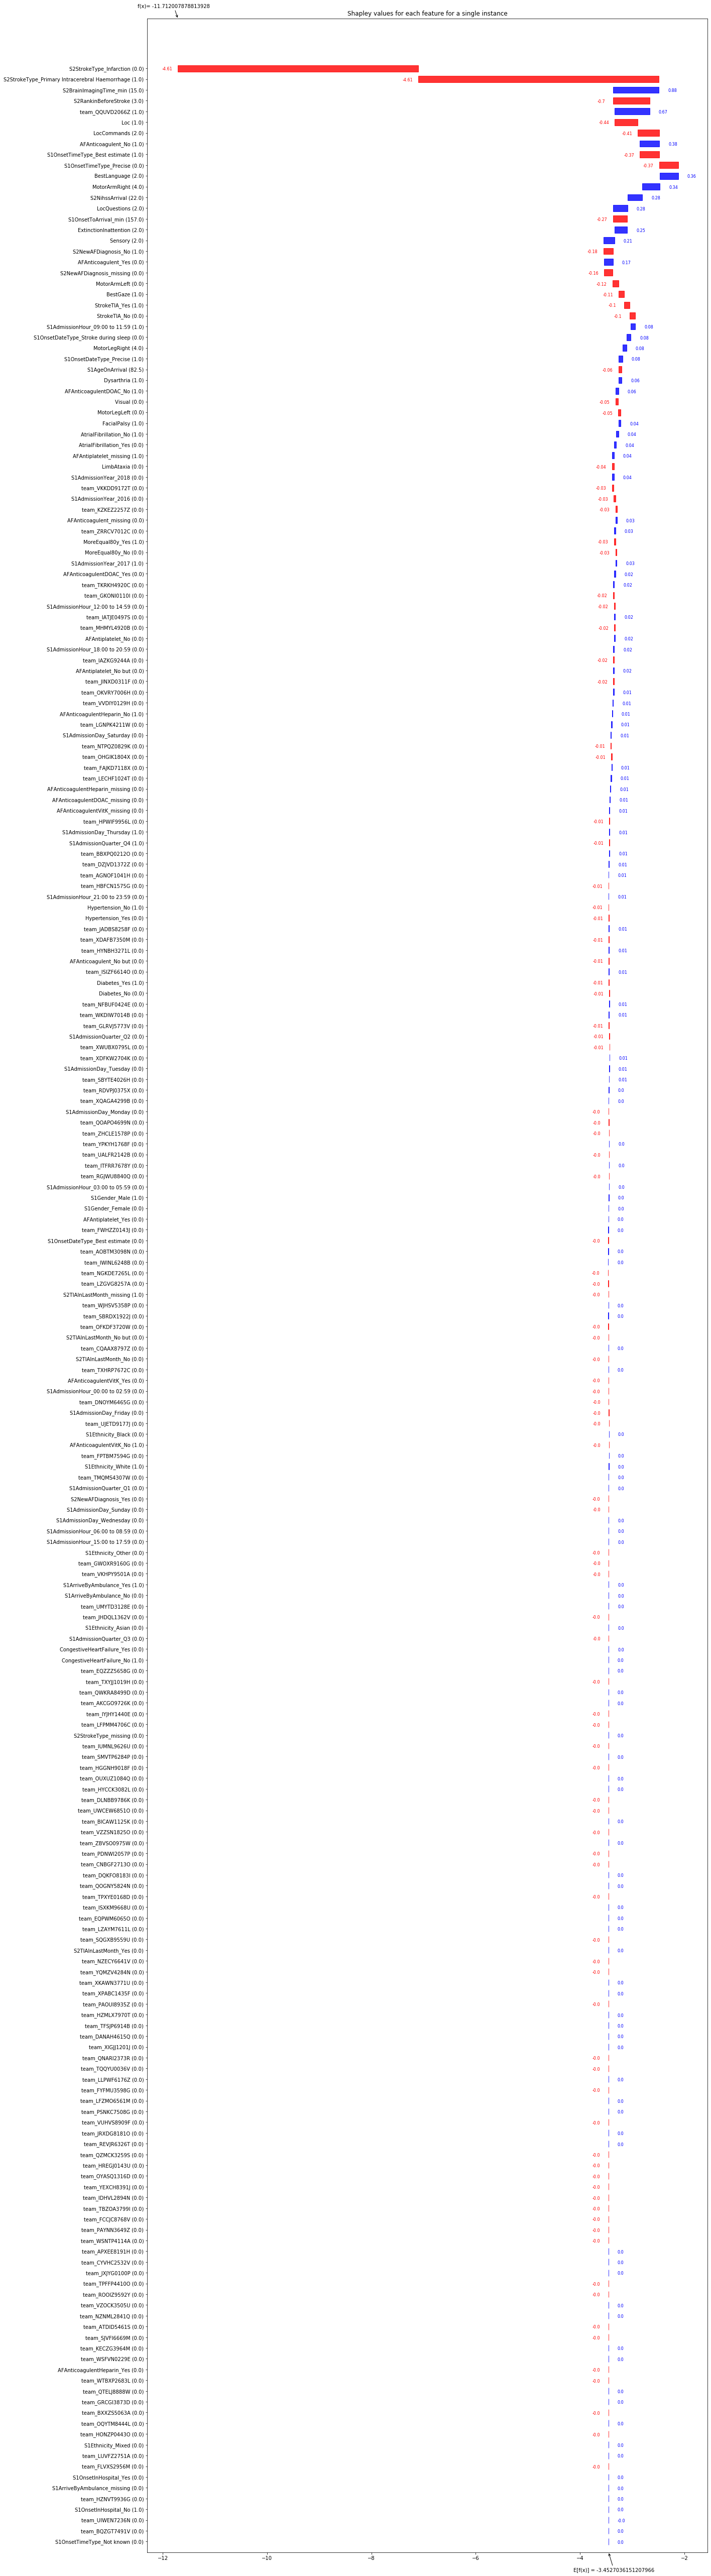

In [61]:
instance = location_low_probability

chosen_instance = X.iloc[instance]
shap_values_instance = shapley_values_df[instance]
expected_value = shapley_values_extended_df.base_values[0]#np.repeat(explainer.expected_value, len(shapley_values))
chosen_predict = y_probs[instance]

waterfall_plot(chosen_instance, 
               shap_values_instance, 
               expected_value,
               chosen_predict)

Remove the features that do not contribute to the predicted value (have a shapley value = 0)

There is a difference between the predicted value from the model and the culmulative sum of the shapley values: 11.712016073570313


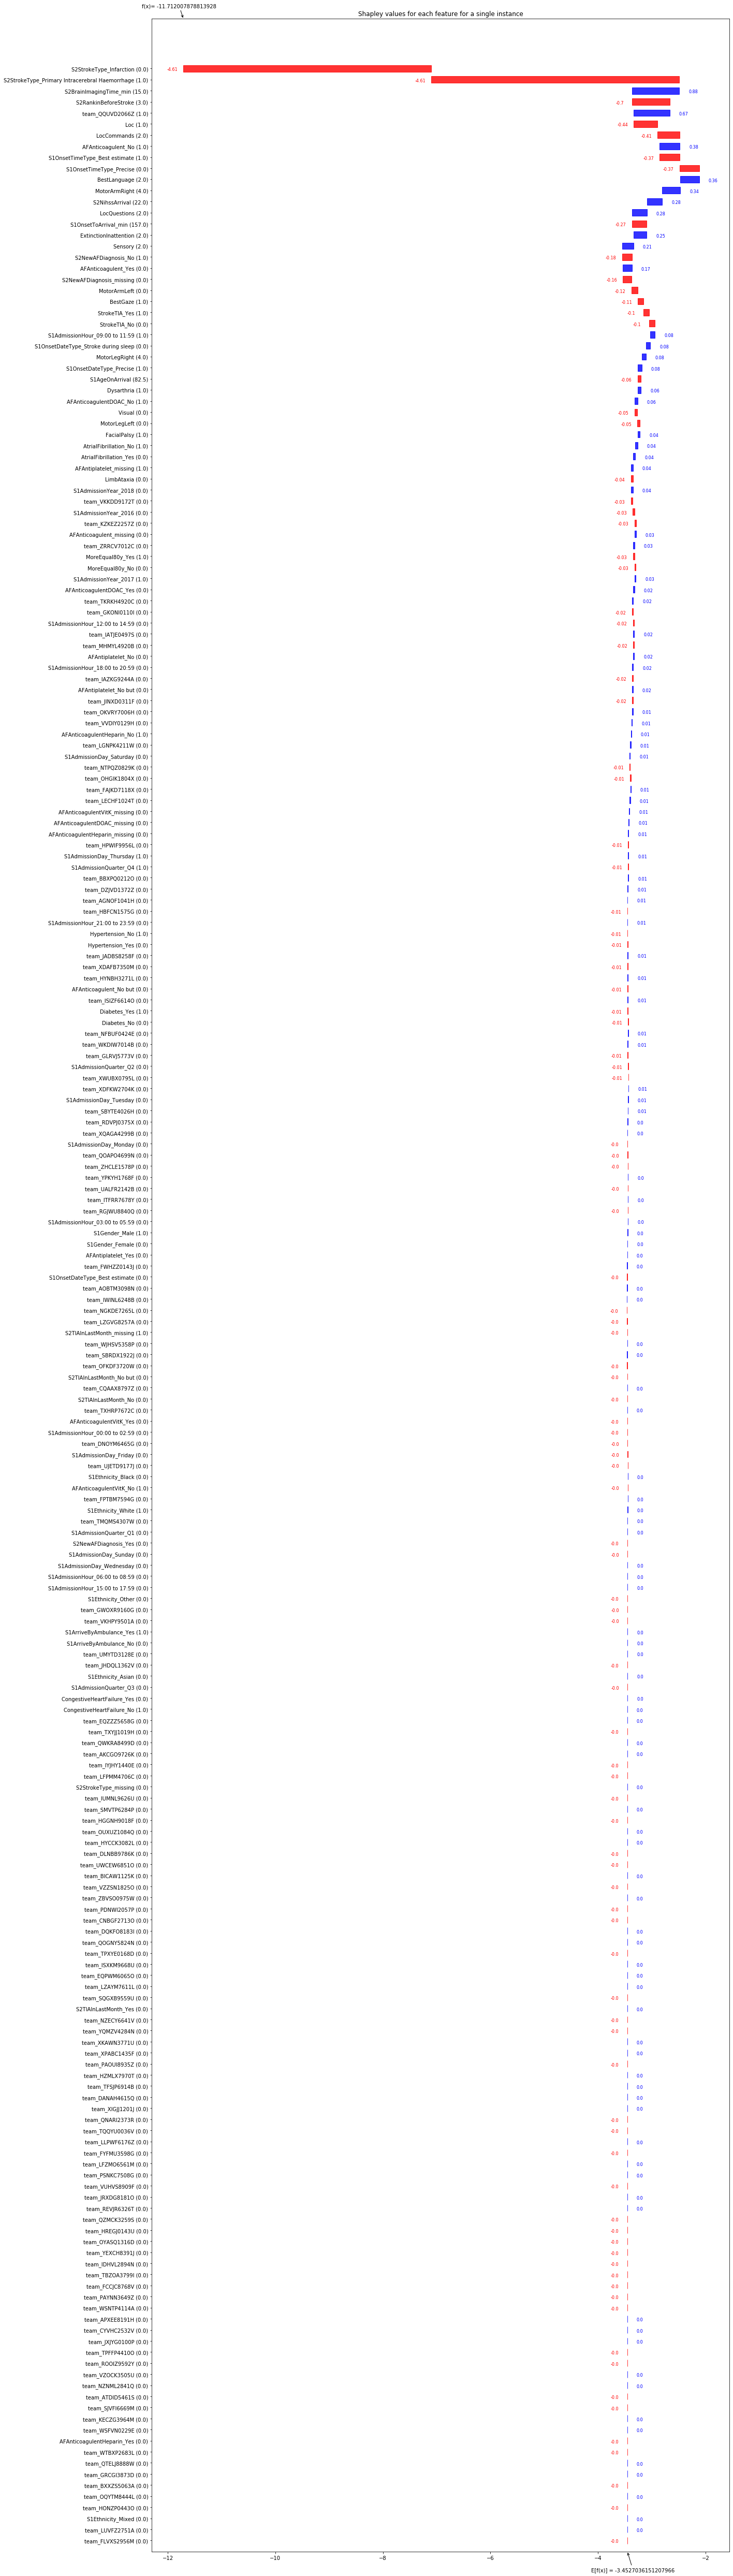

In [62]:
mask = shap_values_instance == 0
mask = np.invert(mask)
chosen_instance_filtered = chosen_instance[mask]
shap_values_instance_filtered = shap_values_instance[mask]
expected_value_filtered =  shapley_values_extended_df.base_values[0]#expected_value[0]
expected_value_filtered

waterfall_plot(chosen_instance_filtered, 
               shap_values_instance_filtered, 
               expected_value_filtered,
               chosen_predict)

Or can specify the top n features to display

There is a difference between the predicted value from the model and the culmulative sum of the shapley values: 11.712016073570311


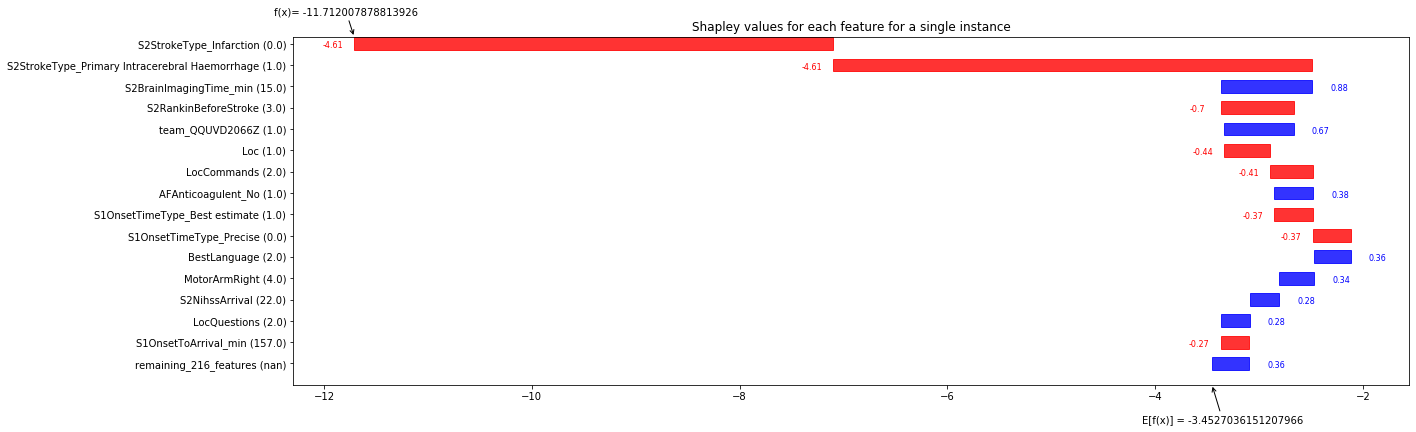

In [63]:
waterfall_plot(chosen_instance, 
               shap_values_instance, 
               expected_value,
               chosen_predict,
               max_display=15)

In [64]:
### Example waterfall plot for a patient with middle probability thrombolysis

There is a difference between the predicted value from the model and the culmulative sum of the shapley values: 0.4954994560811774


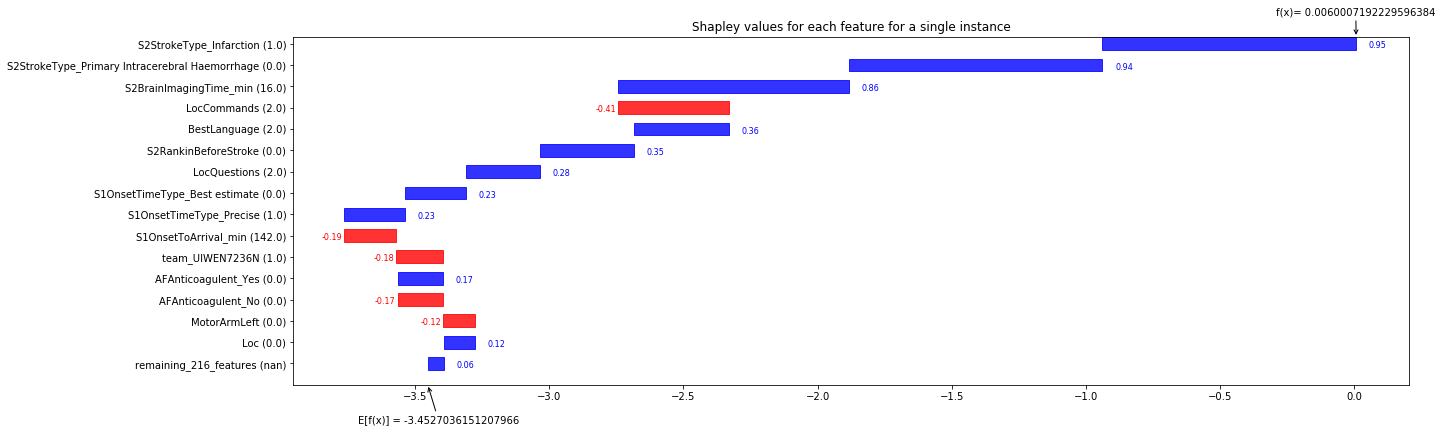

In [65]:
instance = location_middle_probability

chosen_instance = X.iloc[instance]
shap_values_instance = shapley_values_df[instance]
expected_value = shapley_values_extended_df.base_values[0]#np.repeat(explainer.expected_value, len(shapley_values))
chosen_predict = y_probs[instance]

waterfall_plot(chosen_instance, 
               shap_values_instance, 
               expected_value,
               chosen_predict, 
               max_display=15)

In [66]:
### Example waterfall plot for a patient with high probability thrombolysis

There is a difference between the predicted value from the model and the culmulative sum of the shapley values: 3.7031462498978467


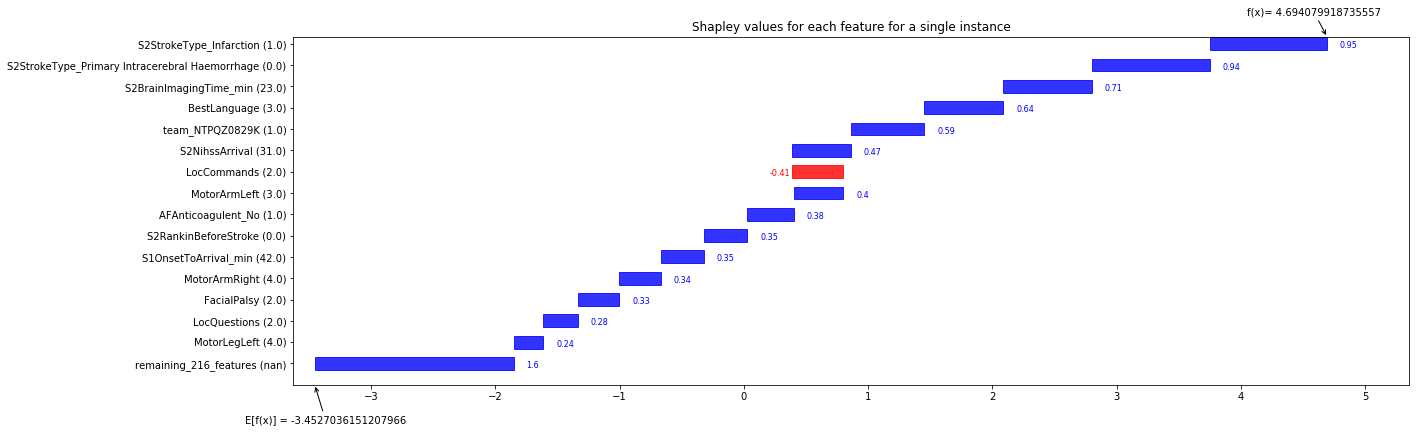

In [67]:
instance = location_high_probability

chosen_instance = X.iloc[instance]
shap_values_instance = shapley_values_df[instance]
expected_value = shapley_values_extended_df.base_values[0]#np.repeat(explainer.expected_value, len(shapley_values))
chosen_predict = y_probs[instance]

waterfall_plot(chosen_instance, 
               shap_values_instance, 
               expected_value,
               chosen_predict, 
               max_display=15)

### Decision plots showing three instances on a subplot (probability)

#### KP (need to check why the top value in the low probability chart is way off the the -ve, when should settle on 0).
#### DIDN'T NEED TO WORK ON THIS AS FOUND CAN PASS AN ARGUMENT TO SHAP.DECISION_PLOT "Like the force plot, the decision plot supports link='logit' to transform log odds to probabilities."

Kept the code here to mark what I was working on.

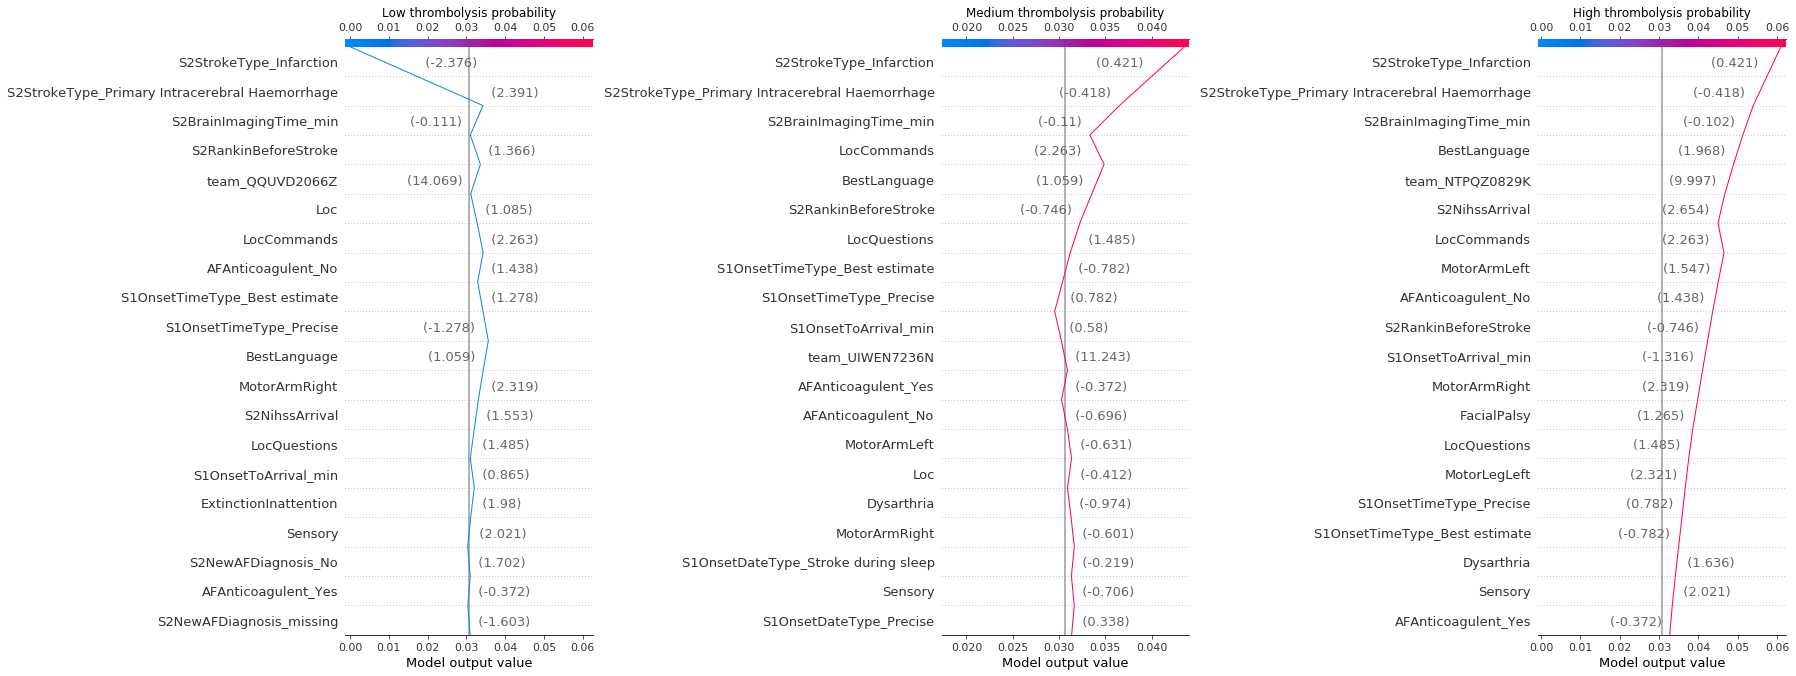

In [68]:
fig = plt.figure(figsize=(10,5))

expected_value = shap_values_transformed.base_values

ax1 = fig.add_subplot(131)
instance = location_low_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shap_values_transformed[instance]
shap.decision_plot(expected_value, shap_values_instance.values, chosen_instance, show=False)
ax1.title.set_text('Low thrombolysis probability')

ax2 = fig.add_subplot(132)
instance = location_middle_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shap_values_transformed.values[instance]
shap.decision_plot(expected_value, shap_values_instance, chosen_instance, show=False)
ax2.title.set_text('Medium thrombolysis probability')

ax3 = fig.add_subplot(133)
instance = location_high_probability
chosen_instance = X_std_df.iloc[instance]
shap_values_instance = shap_values_transformed.values[instance]
shap.decision_plot(expected_value, shap_values_instance, chosen_instance, show=False)
ax3.title.set_text('High thrombolysis probability')

#fig.set_figheight(15)
fig.set_figwidth(25)

plt.tight_layout()
plt.show()